In [1]:
import torch
import torch.nn as nn

import os
import argparse
#from s4_original import S4D
from lava.lib.dl.slayer.state_space_models.s4 import S4D
import os
from lava.utils.system import Loihi2

loihi2_is_available = Loihi2.is_loihi2_available
if loihi2_is_available:
    # Enable SLURM, the workload manager used to distribute Loihi2 resources to users
    os.environ['SLURM'] = '1'
    os.environ['PARTITION'] = "oheogulch"
    os.environ['LOIHI_GEN'] = "N3C1"
import numpy as np

from lava.proc.sdn.process import SigmaDelta, Sigma
from lava.proc.io.source import RingBuffer as SourceBuffer
from lava.proc.io.sink import RingBuffer as SinkBuffer
from lava.proc.embedded_io.spike import PyToNxAdapter, NxToPyAdapter
import matplotlib.pyplot as plt
from src.lava.lib.dl.slayer.state_space_models.s4 import S4D
import torch
from lava.magma.core.run_conditions import RunSteps
from lava.magma.core.run_configs import Loihi2HwCfg, Loihi2SimCfg
from lava.proc.dense.process import Dense
from lava.proc.sdn.process import ActivationMode
from lava.proc.s4d.process import SigmaS4dDelta, S4d
from lava.proc.sparse.process import Sparse
from lava.proc.spike_integrator.process import SpikeIntegrator, SpikeIntegrator32

import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms

import os
import matplotlib.pyplot as plt
import h5py

import torch
import torch.nn.functional as F

import lava.lib.dl.slayer as slayer
import torch
import torchvision
from lava.lib.dl import netx

# Dropout broke in PyTorch 1.11
if tuple(map(int, torch.__version__.split('.')[:2])) == (1, 11):
    print("WARNING: Dropout is bugged in PyTorch 1.11. Results may be worse.")
    dropout_fn = nn.Dropout
if tuple(map(int, torch.__version__.split('.')[:2])) >= (1, 12):
    dropout_fn = nn.Dropout1d
else:
    dropout_fn = nn.Dropout2d
import numpy as np

random_seed = 18
import torch
torch.manual_seed(random_seed)
import random
random.seed(random_seed)
import numpy as np
np.random.seed(random_seed)
from lava.lib.dl.slayer.state_space_models.sCIFAR.networks import SCIFARNetworkTorch
from lava.lib.dl.slayer.state_space_models.sCIFAR import utils


#import random
#random.seed(10)

# S4d
# state = state * A + inp * B
# outp = state * C                                           

# outp += inp * D

# Check relu
# Onchip S4_exp

CUDA extension for structured kernels (Cauchy and Vandermonde multiplication) not found. Install by going to extensions/kernels/ and running `python setup.py install`, for improved speed and memory efficiency. Note that the kernel changed for state-spaces 4.0 and must be recompiled.
Falling back on slow Cauchy and Vandermonde kernel. Install at least one of pykeops or the CUDA extension for better speed and memory efficiency.
CUDA extension for structured kernels (Cauchy and Vandermonde multiplication) not found. Install by going to extensions/kernels/ and running `python setup.py install`, for improved speed and memory efficiency. Note that the kernel changed for state-spaces 4.0 and must be recompiled.
Falling back on slow Cauchy and Vandermonde kernel. Install at least one of pykeops or the CUDA extension for better speed and memory efficiency.


In [2]:
_, _, val_loader = utils.get_datasets() 

Files already downloaded and verified
Files already downloaded and verified


In [3]:
label, data_sample = next(enumerate(val_loader))
label, data_sample = next(enumerate(val_loader))
#label, data_sample = next(enumerate(val_loader))

In [4]:
# Model
print('==> Building model..')
model = SCIFARNetworkTorch(
    d_input=3,
    d_output=10,
    d_model=128,
    d_state=4,
    n_layers=1,
    dropout=0,
    get_last=False,
    quantize=True,
)


model.encoder.qconfig = torch.quantization.default_qat_qconfig
model.ff_layers[0].qconfig = torch.quantization.default_qat_qconfig
model.decoder.qconfig = torch.quantization.default_qat_qconfig
torch.quantization.prepare_qat(model, inplace=True);

checkpoint = torch.load('/home/sveamari/lava_dev/checkpoint/best_with_four_states.pth')
model.load_state_dict(checkpoint['model'])
best_acc = checkpoint['acc']
start_epoch = checkpoint['epoch']
print(best_acc)





model.eval()
model_converted = torch.quantization.convert(model, inplace=False)

==> Building model..


/home/sveamari/lava_dev/.lava_dev/lib/python3.8/site-packages/torch/ao/quantization/observer.py:214: UserWarning: Please use quant_min and quant_max to specify the range for observers.                     reduce_range will be deprecated in a future release of PyTorch.
  warnings.warn(


33.32


In [5]:
# list layers of model
for name, param in model.named_parameters():
    print(name, param.size())       

encoder.weight torch.Size([128, 3])
s4_layers.0.layer.D torch.Size([1, 128])
s4_layers.0.layer.kernel.inv_dt torch.Size([128, 1])
s4_layers.0.layer.kernel.C torch.Size([1, 128, 4])
s4_layers.0.layer.kernel.B torch.Size([1, 128, 4])
s4_layers.0.layer.kernel.A_real torch.Size([128, 4])
ff_layers.0.0.weight torch.Size([128, 128])
decoder.weight torch.Size([10, 128])


In [6]:
inp_exp = 10
full_model_out = model(data_sample[0])


In [7]:
# only send input through first layer of network
encoder_out = model.encoder(data_sample[0])
print(data_sample[0].shape)

#send input through first two layers of model encoder + S4D
s4d_out = model.s4_layers[0](encoder_out)

# send input through first three layers of model encoder + S4D + FF
ff_out = model.ff_layers[0](s4d_out)

# send input through all layers
model_out = model.decoder(ff_out[0])
torch.all(full_model_out == model_out)


torch.Size([1, 1024, 3])


tensor(False)

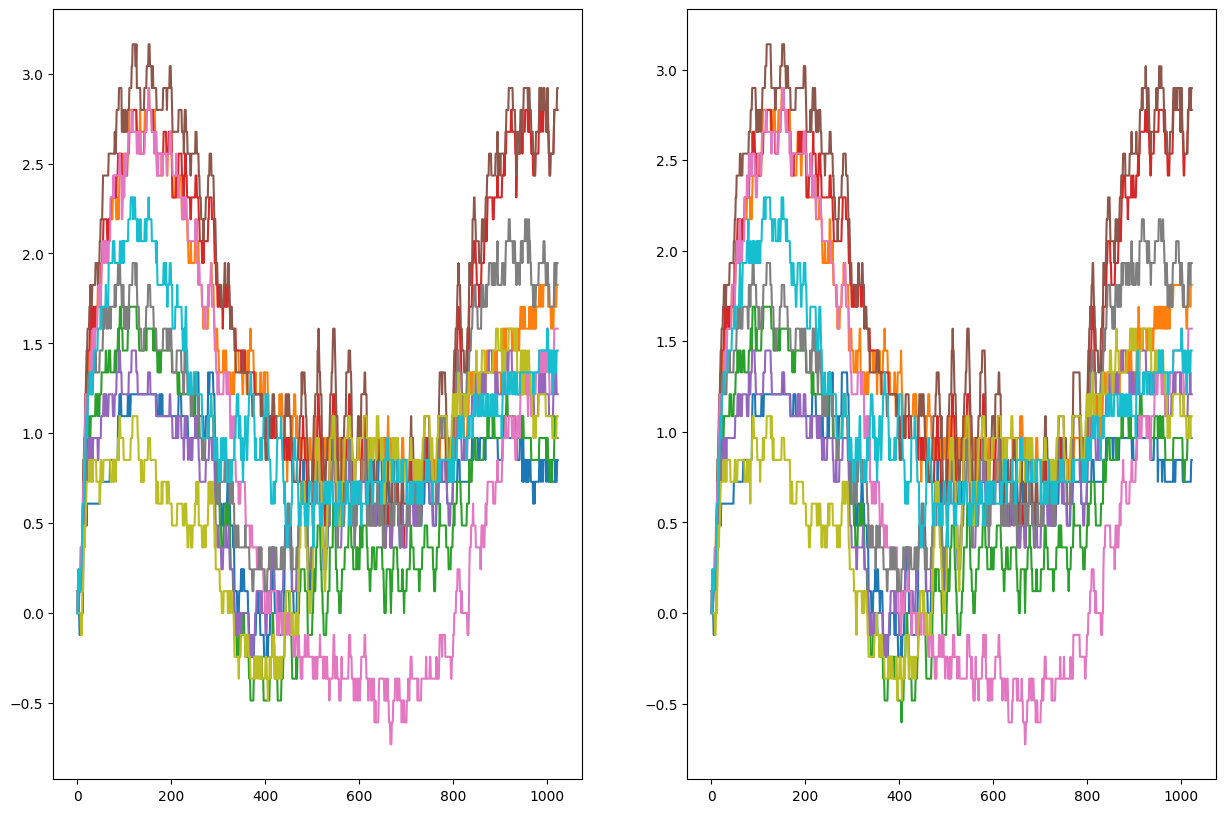

In [8]:
fig, axs = plt.subplots(1, 2, figsize=(15, 10))
axs[0].plot(full_model_out.detach().numpy().squeeze());
axs[1].plot(model_out.detach().numpy().squeeze());    

In [9]:
# get weights
# for encoder
w0 = model_converted.encoder.weight()
wf0 = torch.dequantize(w0)
encoder_weight = wf0 / w0.q_scale()
#print(wq0)
# for ff layer
w1 = model_converted.ff_layers[0][0].weight()
wf1 = torch.dequantize(w1)
ff_weight = wf1 / w1.q_scale()
#print(wq1)
# for decoder
w2 = model_converted.decoder.weight()
wf2 = torch.dequantize(w2)
decoder_weight = wf2 / w2.q_scale()
#print(wq2)

print(w0.q_scale())
print(w1.q_scale())
print(w2.q_scale())


0.012971693649888039
0.017231697216629982
0.007723085582256317


In [10]:
# S4 stuff
model_dim = 128
d_states = 4
model.s4_layers[0].setup_step()
A = model.s4_layers[0].layer.kernel.dA.detach().numpy()
B = model.s4_layers[0].layer.kernel.dB.detach().numpy()
C = model.s4_layers[0].layer.kernel.dC.detach().numpy()

n_steps = 1024 # sequence length
data_sample_final = data_sample[0].detach().numpy().squeeze().T


def example_run(inp, n_layers):
    # 0 just encoder
    # 1 encoder + S4D
    # 2 encoder + S4D + FF
    # 3 full model
    inp_for_lava = inp * 2**inp_exp
    print(f"{inp_exp=}")
    kron_matrix = np.kron(np.eye(model_dim), np.ones((d_states, )))

    # input
    spiker = SourceBuffer(data=inp_for_lava)
    adapter_i = PyToNxAdapter(shape=(3, ), num_message_bits=24)

    #encoder
    dense_1 = Sparse(weights=encoder_weight.numpy(), num_message_bits=24)
    encoder = SpikeIntegrator(shape=(model_dim,), q_scale=w0.q_scale(), q_exp=12, relu_flag=False)

    # S4D
    dense_2 = Sparse(weights=kron_matrix.T, weight_exp=6, num_message_bits=24)
    neuron = S4d(shape=((model_dim * d_states,)), state_exp = 6, s4_exp = 12,    # state exp doesn't get used here, currently hard coded to 6
                            a=A.flatten().reshape((model_dim * d_states,)),
                            b=B.flatten().reshape((model_dim * d_states,)),
                            c=C.flatten().reshape((model_dim * d_states,)))
    dense_3 = Sparse(weights=kron_matrix, num_message_bits=24, weight_exp=6)
    relay = SpikeIntegrator(shape=(model_dim,), relu_flag=False, q_scale=1/(2**6), q_exp=6)

    # FF
    dense_4 = Dense(weights=ff_weight.numpy(), num_message_bits=24)
    ff_neuron = SpikeIntegrator(shape=(model_dim,), relu_flag=True, q_scale=w1.q_scale(), q_exp=12)

    # decoder
    dense_5 = Dense(weights=decoder_weight.numpy(), num_message_bits=24)
    decoder_neuron =SpikeIntegrator(shape=(10,), relu_flag=False, q_scale = w2.q_scale(), q_exp=12)

    # output
    if n_layers in [0,1,2]:
        out_dim = 128
    else:
        out_dim = 10
    adapter_o = NxToPyAdapter(shape=(out_dim,), num_message_bits=24)
    receiver = SinkBuffer(buffer=n_steps, shape=(out_dim,))


    # connect
    spiker.s_out.connect(adapter_i.inp)
    adapter_i.out.connect(dense_1.s_in)
    dense_1.a_out.connect(encoder.a_in)
    
    if n_layers > 0:
        encoder.s_out.connect(dense_2.s_in)
        dense_2.a_out.connect(neuron.a_in)
        neuron.s_out.connect(dense_3.s_in)
        dense_3.a_out.connect(relay.a_in)

    if n_layers > 1:
        relay.s_out.connect(dense_4.s_in)
        dense_4.a_out.connect(ff_neuron.a_in)

    if n_layers > 2:
        ff_neuron.s_out.connect(dense_5.s_in)
        dense_5.a_out.connect(decoder_neuron.a_in)
        decoder_neuron.s_out.connect(adapter_o.inp)

    # output connections
    if n_layers == 0:
        encoder.s_out.connect(adapter_o.inp)
    elif n_layers == 1:
        relay.s_out.connect(adapter_o.inp)
    elif n_layers == 2:
        ff_neuron.s_out.connect(adapter_o.inp)
    

    adapter_o.out.connect(receiver.a_in)
    run_cfg = Loihi2HwCfg()


    
    spiker.run(
                condition=RunSteps(num_steps=n_steps), run_cfg=run_cfg
            )
    received_data_hw = receiver.data.get()
    if n_layers == 1: 
        received_data_hw = (received_data_hw.astype(np.int32)).T
    else:
        received_data_hw = ((received_data_hw.astype(np.int32) << 8) >> 8).T
    encoder.stop()
    return received_data_hw


In [11]:
hw_out_encoder = example_run(data_sample_final, 0)
hw_out_s4d = example_run(data_sample_final, 1)
hw_out_ff = example_run(data_sample_final, 2)
hw_out_full = example_run(data_sample_final, 3)

inp_exp=10


Partitioning converged after iteration=1
Per core utilization:
-------------------------------------------------------------------------
| AxonIn |NeuronGr| Neurons|Synapses| AxonMap| AxonMem|  Total |  Cores |
|-----------------------------------------------------------------------|
|   0.02%|  12.50%|   3.13%|   0.65%|   0.80%|   0.00%|   1.82%|       1|
|-----------------------------------------------------------------------|
| Total                                                        |       1|
-------------------------------------------------------------------------


/home/sveamari/lava_dev/frameworks.ai.nx.nxsdk/nxcore/arch/n3b/n3board.py:77: UserWarning: Loihi generation overriden by environment variable LOIHI_GEN=N3C1
  warnings.warn("Loihi generation overriden by environment variable LOIHI_GEN={}".format(os.environ["LOIHI_GEN"]))


inp_exp=10
Partitioning converged after iteration=1
Per core utilization:
-------------------------------------------------------------------------
| AxonIn |NeuronGr| Neurons|Synapses| AxonMap| AxonMem|  Total |  Cores |
|-----------------------------------------------------------------------|
|   3.20%|  12.50%|   3.13%|   3.20%|   0.80%|   0.00%|   6.41%|       1|
|   0.80%|  12.50%|  25.01%|   0.80%|   3.20%|   0.00%|   8.96%|       1|
|   0.02%|  12.50%|   3.13%|   0.65%|   0.80%|   0.00%|   1.82%|       1|
|-----------------------------------------------------------------------|
| Total                                                        |       3|
-------------------------------------------------------------------------


/home/sveamari/lava_dev/frameworks.ai.nx.nxsdk/nxcore/arch/n3b/n3board.py:77: UserWarning: Loihi generation overriden by environment variable LOIHI_GEN=N3C1
  warnings.warn("Loihi generation overriden by environment variable LOIHI_GEN={}".format(os.environ["LOIHI_GEN"]))


inp_exp=10
Partitioning converged after iteration=1
Per core utilization:
-------------------------------------------------------------------------
| AxonIn |NeuronGr| Neurons|Synapses| AxonMap| AxonMem|  Total |  Cores |
|-----------------------------------------------------------------------|
|   0.80%|  12.50%|   3.13%|  32.80%|   0.80%|   0.00%|  28.16%|       1|
|   3.20%|  12.50%|   3.13%|   3.20%|   0.80%|   0.00%|   6.41%|       1|
|   0.80%|  12.50%|  25.01%|   0.80%|   3.20%|   0.00%|   8.96%|       1|
|   0.02%|  12.50%|   3.13%|   0.65%|   0.80%|   0.00%|   1.82%|       1|
|-----------------------------------------------------------------------|
| Total                                                        |       4|
-------------------------------------------------------------------------


/home/sveamari/lava_dev/frameworks.ai.nx.nxsdk/nxcore/arch/n3b/n3board.py:77: UserWarning: Loihi generation overriden by environment variable LOIHI_GEN=N3C1
  warnings.warn("Loihi generation overriden by environment variable LOIHI_GEN={}".format(os.environ["LOIHI_GEN"]))


inp_exp=10
Partitioning converged after iteration=1
Per core utilization:
-------------------------------------------------------------------------
| AxonIn |NeuronGr| Neurons|Synapses| AxonMap| AxonMem|  Total |  Cores |
|-----------------------------------------------------------------------|
|   0.80%|  12.50%|   0.24%|   3.20%|   0.06%|   0.00%|   3.31%|       1|
|   0.80%|  12.50%|   3.13%|  32.80%|   0.80%|   0.00%|  28.16%|       1|
|   3.20%|  12.50%|   3.13%|   3.20%|   0.80%|   0.00%|   6.41%|       1|
|   0.80%|  12.50%|  25.01%|   0.80%|   3.20%|   0.00%|   8.96%|       1|
|   0.02%|  12.50%|   3.13%|   0.65%|   0.80%|   0.00%|   1.82%|       1|
|-----------------------------------------------------------------------|
| Total                                                        |       5|
-------------------------------------------------------------------------


/home/sveamari/lava_dev/frameworks.ai.nx.nxsdk/nxcore/arch/n3b/n3board.py:77: UserWarning: Loihi generation overriden by environment variable LOIHI_GEN=N3C1
  warnings.warn("Loihi generation overriden by environment variable LOIHI_GEN={}".format(os.environ["LOIHI_GEN"]))


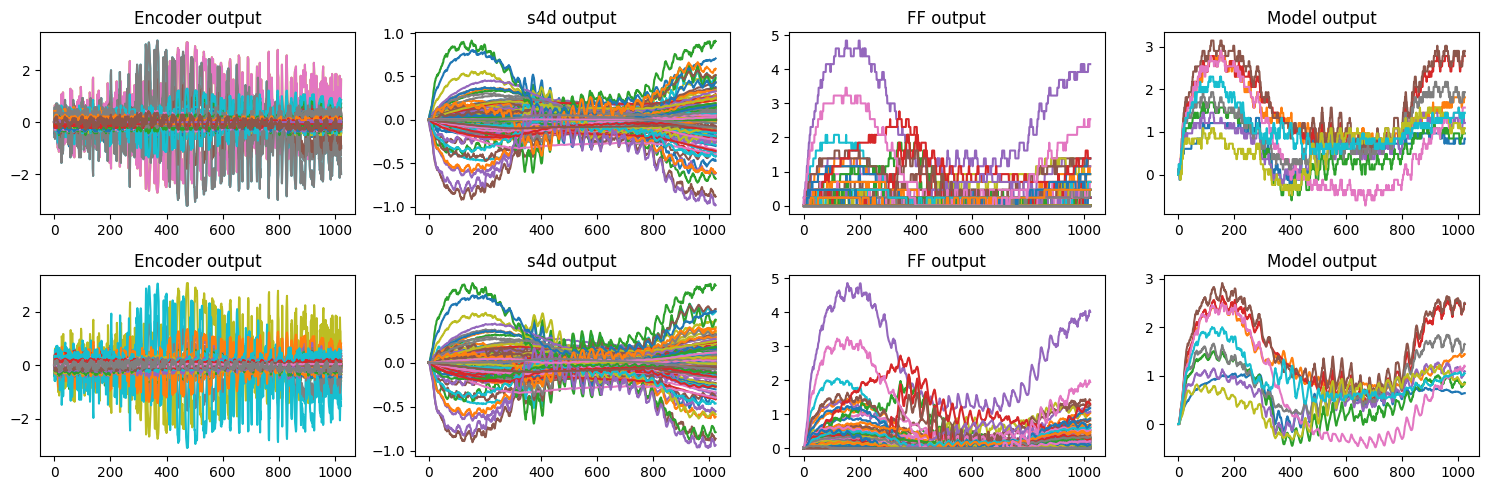

In [12]:
fig, axs = plt.subplots(2, 4, figsize=(15, 5))
axs[0,0].plot(encoder_out.squeeze().detach().numpy());
axs[0,0].set_title('Encoder output')
axs[0,1].plot(s4d_out.squeeze().detach().numpy()),
axs[0,1].set_title('s4d output')   
axs[0,2].plot(ff_out.squeeze().detach().numpy());
axs[0,2].set_title('FF output')
axs[0,3].plot(model_out.squeeze().detach().numpy());
axs[0,3].set_title('Model output')
axs[0,0].plot(encoder_out.squeeze().detach().numpy());
axs[1,0].plot(hw_out_encoder * 2**-inp_exp);
axs[1,0].set_title('Encoder output')
axs[1,1].plot(hw_out_s4d * 2**-inp_exp);
axs[1,1].set_title('s4d output')   
axs[1,2].plot(hw_out_ff * 2**-inp_exp);
axs[1,2].set_title('FF output')
axs[1,3].plot(hw_out_full * 2**-inp_exp);
axs[1,3].set_title('Model output')
# make plots non-overlapping
plt.tight_layout()

inp_exp=10
Partitioning converged after iteration=1
Per core utilization:
-------------------------------------------------------------------------
| AxonIn |NeuronGr| Neurons|Synapses| AxonMap| AxonMem|  Total |  Cores |
|-----------------------------------------------------------------------|
|   0.80%|  12.50%|   0.24%|   3.20%|   0.06%|   0.00%|   3.31%|       1|
|   0.80%|  12.50%|   3.13%|  32.80%|   0.80%|   0.00%|  28.16%|       1|
|   3.20%|  12.50%|   3.13%|   3.20%|   0.80%|   0.00%|   6.41%|       1|
|   0.80%|  12.50%|  25.01%|   0.80%|   3.20%|   0.00%|   8.96%|       1|
|   0.02%|  12.50%|   3.13%|   0.65%|   0.80%|   0.00%|   1.82%|       1|
|-----------------------------------------------------------------------|
| Total                                                        |       5|
-------------------------------------------------------------------------


/home/sveamari/lava_dev/frameworks.ai.nx.nxsdk/nxcore/arch/n3b/n3board.py:77: UserWarning: Loihi generation overriden by environment variable LOIHI_GEN=N3C1
  warnings.warn("Loihi generation overriden by environment variable LOIHI_GEN={}".format(os.environ["LOIHI_GEN"]))


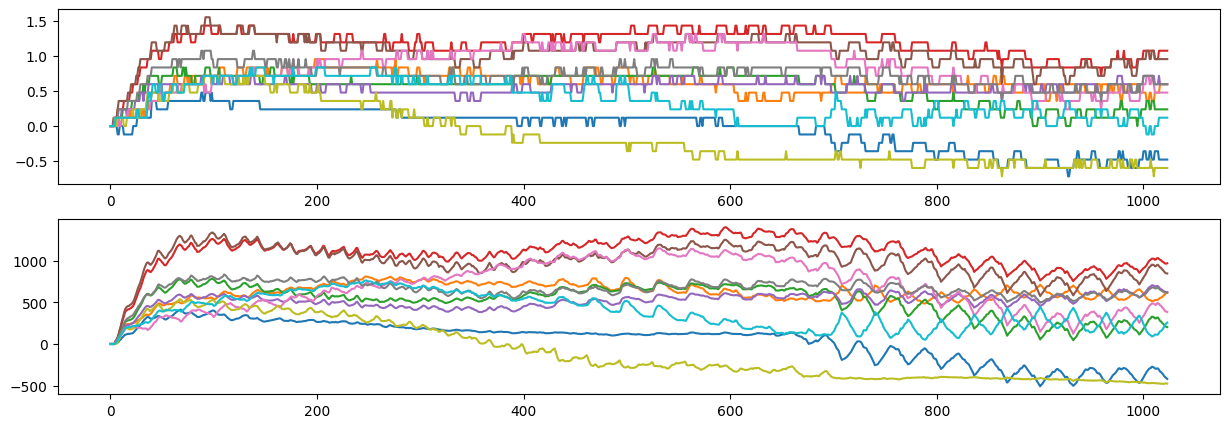

0 tensor([4]) 3 3
inp_exp=10
Partitioning converged after iteration=1
Per core utilization:
-------------------------------------------------------------------------
| AxonIn |NeuronGr| Neurons|Synapses| AxonMap| AxonMem|  Total |  Cores |
|-----------------------------------------------------------------------|
|   0.80%|  12.50%|   0.24%|   3.20%|   0.06%|   0.00%|   3.31%|       1|
|   0.80%|  12.50%|   3.13%|  32.80%|   0.80%|   0.00%|  28.16%|       1|
|   3.20%|  12.50%|   3.13%|   3.20%|   0.80%|   0.00%|   6.41%|       1|
|   0.80%|  12.50%|  25.01%|   0.80%|   3.20%|   0.00%|   8.96%|       1|
|   0.02%|  12.50%|   3.13%|   0.65%|   0.80%|   0.00%|   1.82%|       1|
|-----------------------------------------------------------------------|
| Total                                                        |       5|
-------------------------------------------------------------------------


/home/sveamari/lava_dev/frameworks.ai.nx.nxsdk/nxcore/arch/n3b/n3board.py:77: UserWarning: Loihi generation overriden by environment variable LOIHI_GEN=N3C1
  warnings.warn("Loihi generation overriden by environment variable LOIHI_GEN={}".format(os.environ["LOIHI_GEN"]))


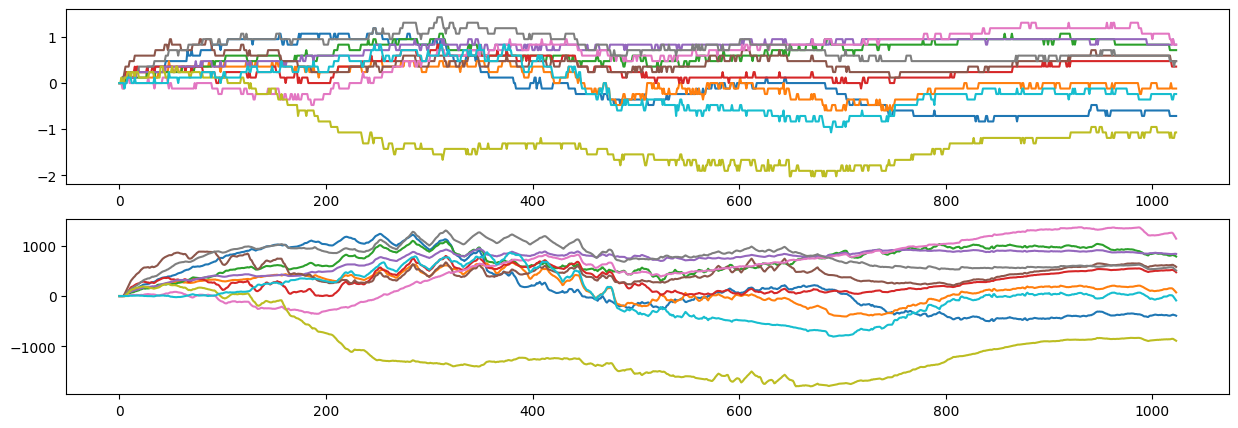

1 tensor([4]) 4 6
accuate pred_dl
inp_exp=10
Partitioning converged after iteration=1
Per core utilization:
-------------------------------------------------------------------------
| AxonIn |NeuronGr| Neurons|Synapses| AxonMap| AxonMem|  Total |  Cores |
|-----------------------------------------------------------------------|
|   0.80%|  12.50%|   0.24%|   3.20%|   0.06%|   0.00%|   3.31%|       1|
|   0.80%|  12.50%|   3.13%|  32.80%|   0.80%|   0.00%|  28.16%|       1|
|   3.20%|  12.50%|   3.13%|   3.20%|   0.80%|   0.00%|   6.41%|       1|
|   0.80%|  12.50%|  25.01%|   0.80%|   3.20%|   0.00%|   8.96%|       1|
|   0.02%|  12.50%|   3.13%|   0.65%|   0.80%|   0.00%|   1.82%|       1|
|-----------------------------------------------------------------------|
| Total                                                        |       5|
-------------------------------------------------------------------------


/home/sveamari/lava_dev/frameworks.ai.nx.nxsdk/nxcore/arch/n3b/n3board.py:77: UserWarning: Loihi generation overriden by environment variable LOIHI_GEN=N3C1
  warnings.warn("Loihi generation overriden by environment variable LOIHI_GEN={}".format(os.environ["LOIHI_GEN"]))


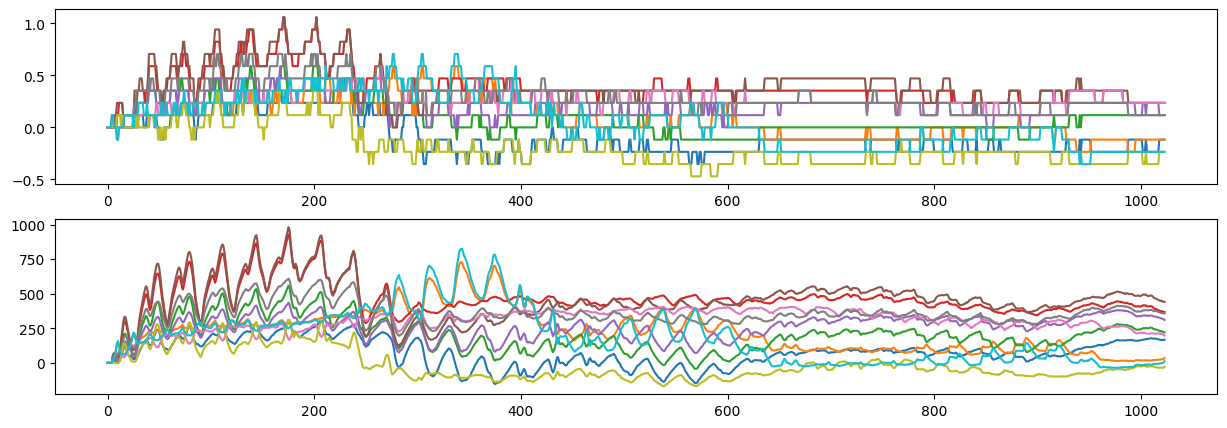

2 tensor([5]) 3 5
accurate lava
inp_exp=10
Partitioning converged after iteration=1
Per core utilization:
-------------------------------------------------------------------------
| AxonIn |NeuronGr| Neurons|Synapses| AxonMap| AxonMem|  Total |  Cores |
|-----------------------------------------------------------------------|
|   0.80%|  12.50%|   0.24%|   3.20%|   0.06%|   0.00%|   3.31%|       1|
|   0.80%|  12.50%|   3.13%|  32.80%|   0.80%|   0.00%|  28.16%|       1|
|   3.20%|  12.50%|   3.13%|   3.20%|   0.80%|   0.00%|   6.41%|       1|
|   0.80%|  12.50%|  25.01%|   0.80%|   3.20%|   0.00%|   8.96%|       1|
|   0.02%|  12.50%|   3.13%|   0.65%|   0.80%|   0.00%|   1.82%|       1|
|-----------------------------------------------------------------------|
| Total                                                        |       5|
-------------------------------------------------------------------------


/home/sveamari/lava_dev/frameworks.ai.nx.nxsdk/nxcore/arch/n3b/n3board.py:77: UserWarning: Loihi generation overriden by environment variable LOIHI_GEN=N3C1
  warnings.warn("Loihi generation overriden by environment variable LOIHI_GEN={}".format(os.environ["LOIHI_GEN"]))


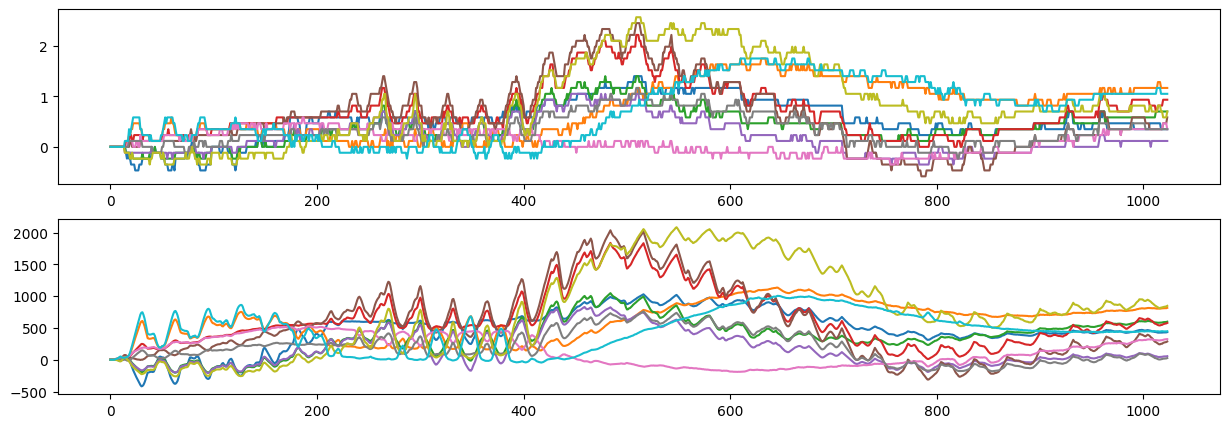

3 tensor([1]) 1 8
accuate pred_dl
inp_exp=10
Partitioning converged after iteration=1
Per core utilization:
-------------------------------------------------------------------------
| AxonIn |NeuronGr| Neurons|Synapses| AxonMap| AxonMem|  Total |  Cores |
|-----------------------------------------------------------------------|
|   0.80%|  12.50%|   0.24%|   3.20%|   0.06%|   0.00%|   3.31%|       1|
|   0.80%|  12.50%|   3.13%|  32.80%|   0.80%|   0.00%|  28.16%|       1|
|   3.20%|  12.50%|   3.13%|   3.20%|   0.80%|   0.00%|   6.41%|       1|
|   0.80%|  12.50%|  25.01%|   0.80%|   3.20%|   0.00%|   8.96%|       1|
|   0.02%|  12.50%|   3.13%|   0.65%|   0.80%|   0.00%|   1.82%|       1|
|-----------------------------------------------------------------------|
| Total                                                        |       5|
-------------------------------------------------------------------------


/home/sveamari/lava_dev/frameworks.ai.nx.nxsdk/nxcore/arch/n3b/n3board.py:77: UserWarning: Loihi generation overriden by environment variable LOIHI_GEN=N3C1
  warnings.warn("Loihi generation overriden by environment variable LOIHI_GEN={}".format(os.environ["LOIHI_GEN"]))


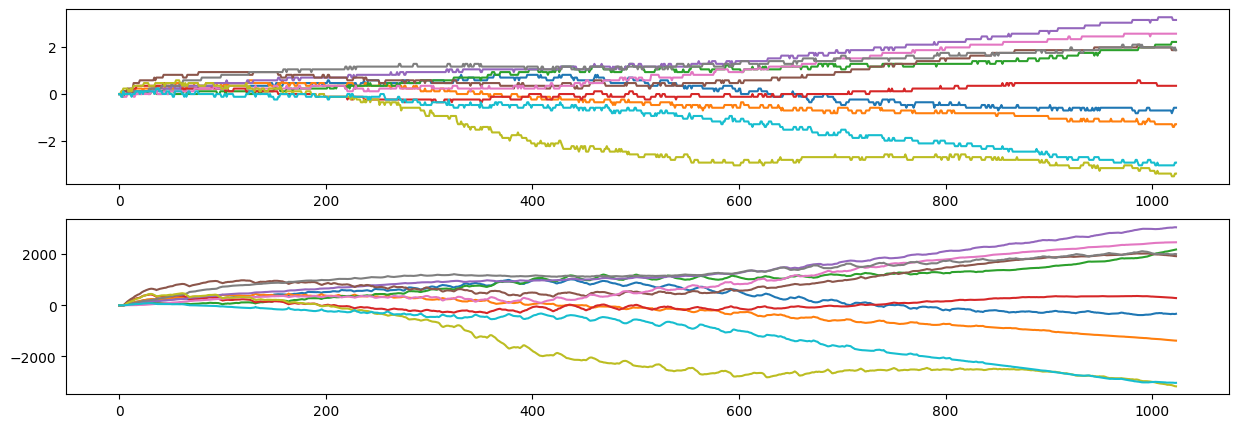

4 tensor([4]) 4 4
accuate pred_dl
accurate lava
inp_exp=10
Partitioning converged after iteration=1
Per core utilization:
-------------------------------------------------------------------------
| AxonIn |NeuronGr| Neurons|Synapses| AxonMap| AxonMem|  Total |  Cores |
|-----------------------------------------------------------------------|
|   0.80%|  12.50%|   0.24%|   3.20%|   0.06%|   0.00%|   3.31%|       1|
|   0.80%|  12.50%|   3.13%|  32.80%|   0.80%|   0.00%|  28.16%|       1|
|   3.20%|  12.50%|   3.13%|   3.20%|   0.80%|   0.00%|   6.41%|       1|
|   0.80%|  12.50%|  25.01%|   0.80%|   3.20%|   0.00%|   8.96%|       1|
|   0.02%|  12.50%|   3.13%|   0.65%|   0.80%|   0.00%|   1.82%|       1|
|-----------------------------------------------------------------------|
| Total                                                        |       5|
-------------------------------------------------------------------------


/home/sveamari/lava_dev/frameworks.ai.nx.nxsdk/nxcore/arch/n3b/n3board.py:77: UserWarning: Loihi generation overriden by environment variable LOIHI_GEN=N3C1
  warnings.warn("Loihi generation overriden by environment variable LOIHI_GEN={}".format(os.environ["LOIHI_GEN"]))


5 tensor([3]) 5 5
inp_exp=10
Partitioning converged after iteration=1
Per core utilization:
-------------------------------------------------------------------------
| AxonIn |NeuronGr| Neurons|Synapses| AxonMap| AxonMem|  Total |  Cores |
|-----------------------------------------------------------------------|
|   0.80%|  12.50%|   0.24%|   3.20%|   0.06%|   0.00%|   3.31%|       1|
|   0.80%|  12.50%|   3.13%|  32.80%|   0.80%|   0.00%|  28.16%|       1|
|   3.20%|  12.50%|   3.13%|   3.20%|   0.80%|   0.00%|   6.41%|       1|
|   0.80%|  12.50%|  25.01%|   0.80%|   3.20%|   0.00%|   8.96%|       1|
|   0.02%|  12.50%|   3.13%|   0.65%|   0.80%|   0.00%|   1.82%|       1|
|-----------------------------------------------------------------------|
| Total                                                        |       5|
-------------------------------------------------------------------------


/home/sveamari/lava_dev/frameworks.ai.nx.nxsdk/nxcore/arch/n3b/n3board.py:77: UserWarning: Loihi generation overriden by environment variable LOIHI_GEN=N3C1
  warnings.warn("Loihi generation overriden by environment variable LOIHI_GEN={}".format(os.environ["LOIHI_GEN"]))


6 tensor([5]) 5 5
accuate pred_dl
accurate lava
inp_exp=10
Partitioning converged after iteration=1
Per core utilization:
-------------------------------------------------------------------------
| AxonIn |NeuronGr| Neurons|Synapses| AxonMap| AxonMem|  Total |  Cores |
|-----------------------------------------------------------------------|
|   0.80%|  12.50%|   0.24%|   3.20%|   0.06%|   0.00%|   3.31%|       1|
|   0.80%|  12.50%|   3.13%|  32.80%|   0.80%|   0.00%|  28.16%|       1|
|   3.20%|  12.50%|   3.13%|   3.20%|   0.80%|   0.00%|   6.41%|       1|
|   0.80%|  12.50%|  25.01%|   0.80%|   3.20%|   0.00%|   8.96%|       1|
|   0.02%|  12.50%|   3.13%|   0.65%|   0.80%|   0.00%|   1.82%|       1|
|-----------------------------------------------------------------------|
| Total                                                        |       5|
-------------------------------------------------------------------------


/home/sveamari/lava_dev/frameworks.ai.nx.nxsdk/nxcore/arch/n3b/n3board.py:77: UserWarning: Loihi generation overriden by environment variable LOIHI_GEN=N3C1
  warnings.warn("Loihi generation overriden by environment variable LOIHI_GEN={}".format(os.environ["LOIHI_GEN"]))


7 tensor([1]) 8 8
inp_exp=10
Partitioning converged after iteration=1
Per core utilization:
-------------------------------------------------------------------------
| AxonIn |NeuronGr| Neurons|Synapses| AxonMap| AxonMem|  Total |  Cores |
|-----------------------------------------------------------------------|
|   0.80%|  12.50%|   0.24%|   3.20%|   0.06%|   0.00%|   3.31%|       1|
|   0.80%|  12.50%|   3.13%|  32.80%|   0.80%|   0.00%|  28.16%|       1|
|   3.20%|  12.50%|   3.13%|   3.20%|   0.80%|   0.00%|   6.41%|       1|
|   0.80%|  12.50%|  25.01%|   0.80%|   3.20%|   0.00%|   8.96%|       1|
|   0.02%|  12.50%|   3.13%|   0.65%|   0.80%|   0.00%|   1.82%|       1|
|-----------------------------------------------------------------------|
| Total                                                        |       5|
-------------------------------------------------------------------------


/home/sveamari/lava_dev/frameworks.ai.nx.nxsdk/nxcore/arch/n3b/n3board.py:77: UserWarning: Loihi generation overriden by environment variable LOIHI_GEN=N3C1
  warnings.warn("Loihi generation overriden by environment variable LOIHI_GEN={}".format(os.environ["LOIHI_GEN"]))


8 tensor([9]) 6 7
inp_exp=10
Partitioning converged after iteration=1
Per core utilization:
-------------------------------------------------------------------------
| AxonIn |NeuronGr| Neurons|Synapses| AxonMap| AxonMem|  Total |  Cores |
|-----------------------------------------------------------------------|
|   0.80%|  12.50%|   0.24%|   3.20%|   0.06%|   0.00%|   3.31%|       1|
|   0.80%|  12.50%|   3.13%|  32.80%|   0.80%|   0.00%|  28.16%|       1|
|   3.20%|  12.50%|   3.13%|   3.20%|   0.80%|   0.00%|   6.41%|       1|
|   0.80%|  12.50%|  25.01%|   0.80%|   3.20%|   0.00%|   8.96%|       1|
|   0.02%|  12.50%|   3.13%|   0.65%|   0.80%|   0.00%|   1.82%|       1|
|-----------------------------------------------------------------------|
| Total                                                        |       5|
-------------------------------------------------------------------------


/home/sveamari/lava_dev/frameworks.ai.nx.nxsdk/nxcore/arch/n3b/n3board.py:77: UserWarning: Loihi generation overriden by environment variable LOIHI_GEN=N3C1
  warnings.warn("Loihi generation overriden by environment variable LOIHI_GEN={}".format(os.environ["LOIHI_GEN"]))


9 tensor([3]) 4 4
inp_exp=10
Partitioning converged after iteration=1
Per core utilization:
-------------------------------------------------------------------------
| AxonIn |NeuronGr| Neurons|Synapses| AxonMap| AxonMem|  Total |  Cores |
|-----------------------------------------------------------------------|
|   0.80%|  12.50%|   0.24%|   3.20%|   0.06%|   0.00%|   3.31%|       1|
|   0.80%|  12.50%|   3.13%|  32.80%|   0.80%|   0.00%|  28.16%|       1|
|   3.20%|  12.50%|   3.13%|   3.20%|   0.80%|   0.00%|   6.41%|       1|
|   0.80%|  12.50%|  25.01%|   0.80%|   3.20%|   0.00%|   8.96%|       1|
|   0.02%|  12.50%|   3.13%|   0.65%|   0.80%|   0.00%|   1.82%|       1|
|-----------------------------------------------------------------------|
| Total                                                        |       5|
-------------------------------------------------------------------------


/home/sveamari/lava_dev/frameworks.ai.nx.nxsdk/nxcore/arch/n3b/n3board.py:77: UserWarning: Loihi generation overriden by environment variable LOIHI_GEN=N3C1
  warnings.warn("Loihi generation overriden by environment variable LOIHI_GEN={}".format(os.environ["LOIHI_GEN"]))


10 tensor([1]) 6 6
inp_exp=10
Partitioning converged after iteration=1
Per core utilization:
-------------------------------------------------------------------------
| AxonIn |NeuronGr| Neurons|Synapses| AxonMap| AxonMem|  Total |  Cores |
|-----------------------------------------------------------------------|
|   0.80%|  12.50%|   0.24%|   3.20%|   0.06%|   0.00%|   3.31%|       1|
|   0.80%|  12.50%|   3.13%|  32.80%|   0.80%|   0.00%|  28.16%|       1|
|   3.20%|  12.50%|   3.13%|   3.20%|   0.80%|   0.00%|   6.41%|       1|
|   0.80%|  12.50%|  25.01%|   0.80%|   3.20%|   0.00%|   8.96%|       1|
|   0.02%|  12.50%|   3.13%|   0.65%|   0.80%|   0.00%|   1.82%|       1|
|-----------------------------------------------------------------------|
| Total                                                        |       5|
-------------------------------------------------------------------------


/home/sveamari/lava_dev/frameworks.ai.nx.nxsdk/nxcore/arch/n3b/n3board.py:77: UserWarning: Loihi generation overriden by environment variable LOIHI_GEN=N3C1
  warnings.warn("Loihi generation overriden by environment variable LOIHI_GEN={}".format(os.environ["LOIHI_GEN"]))


11 tensor([9]) 5 5
inp_exp=10
Partitioning converged after iteration=1
Per core utilization:
-------------------------------------------------------------------------
| AxonIn |NeuronGr| Neurons|Synapses| AxonMap| AxonMem|  Total |  Cores |
|-----------------------------------------------------------------------|
|   0.80%|  12.50%|   0.24%|   3.20%|   0.06%|   0.00%|   3.31%|       1|
|   0.80%|  12.50%|   3.13%|  32.80%|   0.80%|   0.00%|  28.16%|       1|
|   3.20%|  12.50%|   3.13%|   3.20%|   0.80%|   0.00%|   6.41%|       1|
|   0.80%|  12.50%|  25.01%|   0.80%|   3.20%|   0.00%|   8.96%|       1|
|   0.02%|  12.50%|   3.13%|   0.65%|   0.80%|   0.00%|   1.82%|       1|
|-----------------------------------------------------------------------|
| Total                                                        |       5|
-------------------------------------------------------------------------


/home/sveamari/lava_dev/frameworks.ai.nx.nxsdk/nxcore/arch/n3b/n3board.py:77: UserWarning: Loihi generation overriden by environment variable LOIHI_GEN=N3C1
  warnings.warn("Loihi generation overriden by environment variable LOIHI_GEN={}".format(os.environ["LOIHI_GEN"]))


12 tensor([6]) 4 4
inp_exp=10
Partitioning converged after iteration=1
Per core utilization:
-------------------------------------------------------------------------
| AxonIn |NeuronGr| Neurons|Synapses| AxonMap| AxonMem|  Total |  Cores |
|-----------------------------------------------------------------------|
|   0.80%|  12.50%|   0.24%|   3.20%|   0.06%|   0.00%|   3.31%|       1|
|   0.80%|  12.50%|   3.13%|  32.80%|   0.80%|   0.00%|  28.16%|       1|
|   3.20%|  12.50%|   3.13%|   3.20%|   0.80%|   0.00%|   6.41%|       1|
|   0.80%|  12.50%|  25.01%|   0.80%|   3.20%|   0.00%|   8.96%|       1|
|   0.02%|  12.50%|   3.13%|   0.65%|   0.80%|   0.00%|   1.82%|       1|
|-----------------------------------------------------------------------|
| Total                                                        |       5|
-------------------------------------------------------------------------


/home/sveamari/lava_dev/frameworks.ai.nx.nxsdk/nxcore/arch/n3b/n3board.py:77: UserWarning: Loihi generation overriden by environment variable LOIHI_GEN=N3C1
  warnings.warn("Loihi generation overriden by environment variable LOIHI_GEN={}".format(os.environ["LOIHI_GEN"]))


13 tensor([0]) 1 1
inp_exp=10
Partitioning converged after iteration=1
Per core utilization:
-------------------------------------------------------------------------
| AxonIn |NeuronGr| Neurons|Synapses| AxonMap| AxonMem|  Total |  Cores |
|-----------------------------------------------------------------------|
|   0.80%|  12.50%|   0.24%|   3.20%|   0.06%|   0.00%|   3.31%|       1|
|   0.80%|  12.50%|   3.13%|  32.80%|   0.80%|   0.00%|  28.16%|       1|
|   3.20%|  12.50%|   3.13%|   3.20%|   0.80%|   0.00%|   6.41%|       1|
|   0.80%|  12.50%|  25.01%|   0.80%|   3.20%|   0.00%|   8.96%|       1|
|   0.02%|  12.50%|   3.13%|   0.65%|   0.80%|   0.00%|   1.82%|       1|
|-----------------------------------------------------------------------|
| Total                                                        |       5|
-------------------------------------------------------------------------


/home/sveamari/lava_dev/frameworks.ai.nx.nxsdk/nxcore/arch/n3b/n3board.py:77: UserWarning: Loihi generation overriden by environment variable LOIHI_GEN=N3C1
  warnings.warn("Loihi generation overriden by environment variable LOIHI_GEN={}".format(os.environ["LOIHI_GEN"]))


14 tensor([8]) 8 8
accuate pred_dl
accurate lava
inp_exp=10
Partitioning converged after iteration=1
Per core utilization:
-------------------------------------------------------------------------
| AxonIn |NeuronGr| Neurons|Synapses| AxonMap| AxonMem|  Total |  Cores |
|-----------------------------------------------------------------------|
|   0.80%|  12.50%|   0.24%|   3.20%|   0.06%|   0.00%|   3.31%|       1|
|   0.80%|  12.50%|   3.13%|  32.80%|   0.80%|   0.00%|  28.16%|       1|
|   3.20%|  12.50%|   3.13%|   3.20%|   0.80%|   0.00%|   6.41%|       1|
|   0.80%|  12.50%|  25.01%|   0.80%|   3.20%|   0.00%|   8.96%|       1|
|   0.02%|  12.50%|   3.13%|   0.65%|   0.80%|   0.00%|   1.82%|       1|
|-----------------------------------------------------------------------|
| Total                                                        |       5|
-------------------------------------------------------------------------


/home/sveamari/lava_dev/frameworks.ai.nx.nxsdk/nxcore/arch/n3b/n3board.py:77: UserWarning: Loihi generation overriden by environment variable LOIHI_GEN=N3C1
  warnings.warn("Loihi generation overriden by environment variable LOIHI_GEN={}".format(os.environ["LOIHI_GEN"]))


15 tensor([3]) 1 1
inp_exp=10
Partitioning converged after iteration=1
Per core utilization:
-------------------------------------------------------------------------
| AxonIn |NeuronGr| Neurons|Synapses| AxonMap| AxonMem|  Total |  Cores |
|-----------------------------------------------------------------------|
|   0.80%|  12.50%|   0.24%|   3.20%|   0.06%|   0.00%|   3.31%|       1|
|   0.80%|  12.50%|   3.13%|  32.80%|   0.80%|   0.00%|  28.16%|       1|
|   3.20%|  12.50%|   3.13%|   3.20%|   0.80%|   0.00%|   6.41%|       1|
|   0.80%|  12.50%|  25.01%|   0.80%|   3.20%|   0.00%|   8.96%|       1|
|   0.02%|  12.50%|   3.13%|   0.65%|   0.80%|   0.00%|   1.82%|       1|
|-----------------------------------------------------------------------|
| Total                                                        |       5|
-------------------------------------------------------------------------


/home/sveamari/lava_dev/frameworks.ai.nx.nxsdk/nxcore/arch/n3b/n3board.py:77: UserWarning: Loihi generation overriden by environment variable LOIHI_GEN=N3C1
  warnings.warn("Loihi generation overriden by environment variable LOIHI_GEN={}".format(os.environ["LOIHI_GEN"]))


16 tensor([3]) 6 2
inp_exp=10
Partitioning converged after iteration=1
Per core utilization:
-------------------------------------------------------------------------
| AxonIn |NeuronGr| Neurons|Synapses| AxonMap| AxonMem|  Total |  Cores |
|-----------------------------------------------------------------------|
|   0.80%|  12.50%|   0.24%|   3.20%|   0.06%|   0.00%|   3.31%|       1|
|   0.80%|  12.50%|   3.13%|  32.80%|   0.80%|   0.00%|  28.16%|       1|
|   3.20%|  12.50%|   3.13%|   3.20%|   0.80%|   0.00%|   6.41%|       1|
|   0.80%|  12.50%|  25.01%|   0.80%|   3.20%|   0.00%|   8.96%|       1|
|   0.02%|  12.50%|   3.13%|   0.65%|   0.80%|   0.00%|   1.82%|       1|
|-----------------------------------------------------------------------|
| Total                                                        |       5|
-------------------------------------------------------------------------


/home/sveamari/lava_dev/frameworks.ai.nx.nxsdk/nxcore/arch/n3b/n3board.py:77: UserWarning: Loihi generation overriden by environment variable LOIHI_GEN=N3C1
  warnings.warn("Loihi generation overriden by environment variable LOIHI_GEN={}".format(os.environ["LOIHI_GEN"]))


17 tensor([8]) 8 8
accuate pred_dl
accurate lava
inp_exp=10
Partitioning converged after iteration=1
Per core utilization:
-------------------------------------------------------------------------
| AxonIn |NeuronGr| Neurons|Synapses| AxonMap| AxonMem|  Total |  Cores |
|-----------------------------------------------------------------------|
|   0.80%|  12.50%|   0.24%|   3.20%|   0.06%|   0.00%|   3.31%|       1|
|   0.80%|  12.50%|   3.13%|  32.80%|   0.80%|   0.00%|  28.16%|       1|
|   3.20%|  12.50%|   3.13%|   3.20%|   0.80%|   0.00%|   6.41%|       1|
|   0.80%|  12.50%|  25.01%|   0.80%|   3.20%|   0.00%|   8.96%|       1|
|   0.02%|  12.50%|   3.13%|   0.65%|   0.80%|   0.00%|   1.82%|       1|
|-----------------------------------------------------------------------|
| Total                                                        |       5|
-------------------------------------------------------------------------


/home/sveamari/lava_dev/frameworks.ai.nx.nxsdk/nxcore/arch/n3b/n3board.py:77: UserWarning: Loihi generation overriden by environment variable LOIHI_GEN=N3C1
  warnings.warn("Loihi generation overriden by environment variable LOIHI_GEN={}".format(os.environ["LOIHI_GEN"]))


18 tensor([5]) 3 3
inp_exp=10
Partitioning converged after iteration=1
Per core utilization:
-------------------------------------------------------------------------
| AxonIn |NeuronGr| Neurons|Synapses| AxonMap| AxonMem|  Total |  Cores |
|-----------------------------------------------------------------------|
|   0.80%|  12.50%|   0.24%|   3.20%|   0.06%|   0.00%|   3.31%|       1|
|   0.80%|  12.50%|   3.13%|  32.80%|   0.80%|   0.00%|  28.16%|       1|
|   3.20%|  12.50%|   3.13%|   3.20%|   0.80%|   0.00%|   6.41%|       1|
|   0.80%|  12.50%|  25.01%|   0.80%|   3.20%|   0.00%|   8.96%|       1|
|   0.02%|  12.50%|   3.13%|   0.65%|   0.80%|   0.00%|   1.82%|       1|
|-----------------------------------------------------------------------|
| Total                                                        |       5|
-------------------------------------------------------------------------


/home/sveamari/lava_dev/frameworks.ai.nx.nxsdk/nxcore/arch/n3b/n3board.py:77: UserWarning: Loihi generation overriden by environment variable LOIHI_GEN=N3C1
  warnings.warn("Loihi generation overriden by environment variable LOIHI_GEN={}".format(os.environ["LOIHI_GEN"]))


19 tensor([1]) 9 9
inp_exp=10
Partitioning converged after iteration=1
Per core utilization:
-------------------------------------------------------------------------
| AxonIn |NeuronGr| Neurons|Synapses| AxonMap| AxonMem|  Total |  Cores |
|-----------------------------------------------------------------------|
|   0.80%|  12.50%|   0.24%|   3.20%|   0.06%|   0.00%|   3.31%|       1|
|   0.80%|  12.50%|   3.13%|  32.80%|   0.80%|   0.00%|  28.16%|       1|
|   3.20%|  12.50%|   3.13%|   3.20%|   0.80%|   0.00%|   6.41%|       1|
|   0.80%|  12.50%|  25.01%|   0.80%|   3.20%|   0.00%|   8.96%|       1|
|   0.02%|  12.50%|   3.13%|   0.65%|   0.80%|   0.00%|   1.82%|       1|
|-----------------------------------------------------------------------|
| Total                                                        |       5|
-------------------------------------------------------------------------


/home/sveamari/lava_dev/frameworks.ai.nx.nxsdk/nxcore/arch/n3b/n3board.py:77: UserWarning: Loihi generation overriden by environment variable LOIHI_GEN=N3C1
  warnings.warn("Loihi generation overriden by environment variable LOIHI_GEN={}".format(os.environ["LOIHI_GEN"]))


20 tensor([5]) 4 4
inp_exp=10
Partitioning converged after iteration=1
Per core utilization:
-------------------------------------------------------------------------
| AxonIn |NeuronGr| Neurons|Synapses| AxonMap| AxonMem|  Total |  Cores |
|-----------------------------------------------------------------------|
|   0.80%|  12.50%|   0.24%|   3.20%|   0.06%|   0.00%|   3.31%|       1|
|   0.80%|  12.50%|   3.13%|  32.80%|   0.80%|   0.00%|  28.16%|       1|
|   3.20%|  12.50%|   3.13%|   3.20%|   0.80%|   0.00%|   6.41%|       1|
|   0.80%|  12.50%|  25.01%|   0.80%|   3.20%|   0.00%|   8.96%|       1|
|   0.02%|  12.50%|   3.13%|   0.65%|   0.80%|   0.00%|   1.82%|       1|
|-----------------------------------------------------------------------|
| Total                                                        |       5|
-------------------------------------------------------------------------


/home/sveamari/lava_dev/frameworks.ai.nx.nxsdk/nxcore/arch/n3b/n3board.py:77: UserWarning: Loihi generation overriden by environment variable LOIHI_GEN=N3C1
  warnings.warn("Loihi generation overriden by environment variable LOIHI_GEN={}".format(os.environ["LOIHI_GEN"]))


21 tensor([7]) 4 4
inp_exp=10
Partitioning converged after iteration=1
Per core utilization:
-------------------------------------------------------------------------
| AxonIn |NeuronGr| Neurons|Synapses| AxonMap| AxonMem|  Total |  Cores |
|-----------------------------------------------------------------------|
|   0.80%|  12.50%|   0.24%|   3.20%|   0.06%|   0.00%|   3.31%|       1|
|   0.80%|  12.50%|   3.13%|  32.80%|   0.80%|   0.00%|  28.16%|       1|
|   3.20%|  12.50%|   3.13%|   3.20%|   0.80%|   0.00%|   6.41%|       1|
|   0.80%|  12.50%|  25.01%|   0.80%|   3.20%|   0.00%|   8.96%|       1|
|   0.02%|  12.50%|   3.13%|   0.65%|   0.80%|   0.00%|   1.82%|       1|
|-----------------------------------------------------------------------|
| Total                                                        |       5|
-------------------------------------------------------------------------


/home/sveamari/lava_dev/frameworks.ai.nx.nxsdk/nxcore/arch/n3b/n3board.py:77: UserWarning: Loihi generation overriden by environment variable LOIHI_GEN=N3C1
  warnings.warn("Loihi generation overriden by environment variable LOIHI_GEN={}".format(os.environ["LOIHI_GEN"]))


22 tensor([1]) 3 3
inp_exp=10
Partitioning converged after iteration=1
Per core utilization:
-------------------------------------------------------------------------
| AxonIn |NeuronGr| Neurons|Synapses| AxonMap| AxonMem|  Total |  Cores |
|-----------------------------------------------------------------------|
|   0.80%|  12.50%|   0.24%|   3.20%|   0.06%|   0.00%|   3.31%|       1|
|   0.80%|  12.50%|   3.13%|  32.80%|   0.80%|   0.00%|  28.16%|       1|
|   3.20%|  12.50%|   3.13%|   3.20%|   0.80%|   0.00%|   6.41%|       1|
|   0.80%|  12.50%|  25.01%|   0.80%|   3.20%|   0.00%|   8.96%|       1|
|   0.02%|  12.50%|   3.13%|   0.65%|   0.80%|   0.00%|   1.82%|       1|
|-----------------------------------------------------------------------|
| Total                                                        |       5|
-------------------------------------------------------------------------


/home/sveamari/lava_dev/frameworks.ai.nx.nxsdk/nxcore/arch/n3b/n3board.py:77: UserWarning: Loihi generation overriden by environment variable LOIHI_GEN=N3C1
  warnings.warn("Loihi generation overriden by environment variable LOIHI_GEN={}".format(os.environ["LOIHI_GEN"]))


23 tensor([5]) 9 9
inp_exp=10
Partitioning converged after iteration=1
Per core utilization:
-------------------------------------------------------------------------
| AxonIn |NeuronGr| Neurons|Synapses| AxonMap| AxonMem|  Total |  Cores |
|-----------------------------------------------------------------------|
|   0.80%|  12.50%|   0.24%|   3.20%|   0.06%|   0.00%|   3.31%|       1|
|   0.80%|  12.50%|   3.13%|  32.80%|   0.80%|   0.00%|  28.16%|       1|
|   3.20%|  12.50%|   3.13%|   3.20%|   0.80%|   0.00%|   6.41%|       1|
|   0.80%|  12.50%|  25.01%|   0.80%|   3.20%|   0.00%|   8.96%|       1|
|   0.02%|  12.50%|   3.13%|   0.65%|   0.80%|   0.00%|   1.82%|       1|
|-----------------------------------------------------------------------|
| Total                                                        |       5|
-------------------------------------------------------------------------


/home/sveamari/lava_dev/frameworks.ai.nx.nxsdk/nxcore/arch/n3b/n3board.py:77: UserWarning: Loihi generation overriden by environment variable LOIHI_GEN=N3C1
  warnings.warn("Loihi generation overriden by environment variable LOIHI_GEN={}".format(os.environ["LOIHI_GEN"]))


24 tensor([5]) 7 7
inp_exp=10
Partitioning converged after iteration=1
Per core utilization:
-------------------------------------------------------------------------
| AxonIn |NeuronGr| Neurons|Synapses| AxonMap| AxonMem|  Total |  Cores |
|-----------------------------------------------------------------------|
|   0.80%|  12.50%|   0.24%|   3.20%|   0.06%|   0.00%|   3.31%|       1|
|   0.80%|  12.50%|   3.13%|  32.80%|   0.80%|   0.00%|  28.16%|       1|
|   3.20%|  12.50%|   3.13%|   3.20%|   0.80%|   0.00%|   6.41%|       1|
|   0.80%|  12.50%|  25.01%|   0.80%|   3.20%|   0.00%|   8.96%|       1|
|   0.02%|  12.50%|   3.13%|   0.65%|   0.80%|   0.00%|   1.82%|       1|
|-----------------------------------------------------------------------|
| Total                                                        |       5|
-------------------------------------------------------------------------


/home/sveamari/lava_dev/frameworks.ai.nx.nxsdk/nxcore/arch/n3b/n3board.py:77: UserWarning: Loihi generation overriden by environment variable LOIHI_GEN=N3C1
  warnings.warn("Loihi generation overriden by environment variable LOIHI_GEN={}".format(os.environ["LOIHI_GEN"]))


25 tensor([1]) 1 1
accuate pred_dl
accurate lava
inp_exp=10
Partitioning converged after iteration=1
Per core utilization:
-------------------------------------------------------------------------
| AxonIn |NeuronGr| Neurons|Synapses| AxonMap| AxonMem|  Total |  Cores |
|-----------------------------------------------------------------------|
|   0.80%|  12.50%|   0.24%|   3.20%|   0.06%|   0.00%|   3.31%|       1|
|   0.80%|  12.50%|   3.13%|  32.80%|   0.80%|   0.00%|  28.16%|       1|
|   3.20%|  12.50%|   3.13%|   3.20%|   0.80%|   0.00%|   6.41%|       1|
|   0.80%|  12.50%|  25.01%|   0.80%|   3.20%|   0.00%|   8.96%|       1|
|   0.02%|  12.50%|   3.13%|   0.65%|   0.80%|   0.00%|   1.82%|       1|
|-----------------------------------------------------------------------|
| Total                                                        |       5|
-------------------------------------------------------------------------


/home/sveamari/lava_dev/frameworks.ai.nx.nxsdk/nxcore/arch/n3b/n3board.py:77: UserWarning: Loihi generation overriden by environment variable LOIHI_GEN=N3C1
  warnings.warn("Loihi generation overriden by environment variable LOIHI_GEN={}".format(os.environ["LOIHI_GEN"]))


26 tensor([8]) 8 0
accuate pred_dl
inp_exp=10
Partitioning converged after iteration=1
Per core utilization:
-------------------------------------------------------------------------
| AxonIn |NeuronGr| Neurons|Synapses| AxonMap| AxonMem|  Total |  Cores |
|-----------------------------------------------------------------------|
|   0.80%|  12.50%|   0.24%|   3.20%|   0.06%|   0.00%|   3.31%|       1|
|   0.80%|  12.50%|   3.13%|  32.80%|   0.80%|   0.00%|  28.16%|       1|
|   3.20%|  12.50%|   3.13%|   3.20%|   0.80%|   0.00%|   6.41%|       1|
|   0.80%|  12.50%|  25.01%|   0.80%|   3.20%|   0.00%|   8.96%|       1|
|   0.02%|  12.50%|   3.13%|   0.65%|   0.80%|   0.00%|   1.82%|       1|
|-----------------------------------------------------------------------|
| Total                                                        |       5|
-------------------------------------------------------------------------


/home/sveamari/lava_dev/frameworks.ai.nx.nxsdk/nxcore/arch/n3b/n3board.py:77: UserWarning: Loihi generation overriden by environment variable LOIHI_GEN=N3C1
  warnings.warn("Loihi generation overriden by environment variable LOIHI_GEN={}".format(os.environ["LOIHI_GEN"]))


27 tensor([1]) 9 9
inp_exp=10
Partitioning converged after iteration=1
Per core utilization:
-------------------------------------------------------------------------
| AxonIn |NeuronGr| Neurons|Synapses| AxonMap| AxonMem|  Total |  Cores |
|-----------------------------------------------------------------------|
|   0.80%|  12.50%|   0.24%|   3.20%|   0.06%|   0.00%|   3.31%|       1|
|   0.80%|  12.50%|   3.13%|  32.80%|   0.80%|   0.00%|  28.16%|       1|
|   3.20%|  12.50%|   3.13%|   3.20%|   0.80%|   0.00%|   6.41%|       1|
|   0.80%|  12.50%|  25.01%|   0.80%|   3.20%|   0.00%|   8.96%|       1|
|   0.02%|  12.50%|   3.13%|   0.65%|   0.80%|   0.00%|   1.82%|       1|
|-----------------------------------------------------------------------|
| Total                                                        |       5|
-------------------------------------------------------------------------


/home/sveamari/lava_dev/frameworks.ai.nx.nxsdk/nxcore/arch/n3b/n3board.py:77: UserWarning: Loihi generation overriden by environment variable LOIHI_GEN=N3C1
  warnings.warn("Loihi generation overriden by environment variable LOIHI_GEN={}".format(os.environ["LOIHI_GEN"]))


28 tensor([3]) 6 6
inp_exp=10
Partitioning converged after iteration=1
Per core utilization:
-------------------------------------------------------------------------
| AxonIn |NeuronGr| Neurons|Synapses| AxonMap| AxonMem|  Total |  Cores |
|-----------------------------------------------------------------------|
|   0.80%|  12.50%|   0.24%|   3.20%|   0.06%|   0.00%|   3.31%|       1|
|   0.80%|  12.50%|   3.13%|  32.80%|   0.80%|   0.00%|  28.16%|       1|
|   3.20%|  12.50%|   3.13%|   3.20%|   0.80%|   0.00%|   6.41%|       1|
|   0.80%|  12.50%|  25.01%|   0.80%|   3.20%|   0.00%|   8.96%|       1|
|   0.02%|  12.50%|   3.13%|   0.65%|   0.80%|   0.00%|   1.82%|       1|
|-----------------------------------------------------------------------|
| Total                                                        |       5|
-------------------------------------------------------------------------


/home/sveamari/lava_dev/frameworks.ai.nx.nxsdk/nxcore/arch/n3b/n3board.py:77: UserWarning: Loihi generation overriden by environment variable LOIHI_GEN=N3C1
  warnings.warn("Loihi generation overriden by environment variable LOIHI_GEN={}".format(os.environ["LOIHI_GEN"]))


29 tensor([5]) 3 3
inp_exp=10
Partitioning converged after iteration=1
Per core utilization:
-------------------------------------------------------------------------
| AxonIn |NeuronGr| Neurons|Synapses| AxonMap| AxonMem|  Total |  Cores |
|-----------------------------------------------------------------------|
|   0.80%|  12.50%|   0.24%|   3.20%|   0.06%|   0.00%|   3.31%|       1|
|   0.80%|  12.50%|   3.13%|  32.80%|   0.80%|   0.00%|  28.16%|       1|
|   3.20%|  12.50%|   3.13%|   3.20%|   0.80%|   0.00%|   6.41%|       1|
|   0.80%|  12.50%|  25.01%|   0.80%|   3.20%|   0.00%|   8.96%|       1|
|   0.02%|  12.50%|   3.13%|   0.65%|   0.80%|   0.00%|   1.82%|       1|
|-----------------------------------------------------------------------|
| Total                                                        |       5|
-------------------------------------------------------------------------


/home/sveamari/lava_dev/frameworks.ai.nx.nxsdk/nxcore/arch/n3b/n3board.py:77: UserWarning: Loihi generation overriden by environment variable LOIHI_GEN=N3C1
  warnings.warn("Loihi generation overriden by environment variable LOIHI_GEN={}".format(os.environ["LOIHI_GEN"]))


30 tensor([1]) 8 8
inp_exp=10
Partitioning converged after iteration=1
Per core utilization:
-------------------------------------------------------------------------
| AxonIn |NeuronGr| Neurons|Synapses| AxonMap| AxonMem|  Total |  Cores |
|-----------------------------------------------------------------------|
|   0.80%|  12.50%|   0.24%|   3.20%|   0.06%|   0.00%|   3.31%|       1|
|   0.80%|  12.50%|   3.13%|  32.80%|   0.80%|   0.00%|  28.16%|       1|
|   3.20%|  12.50%|   3.13%|   3.20%|   0.80%|   0.00%|   6.41%|       1|
|   0.80%|  12.50%|  25.01%|   0.80%|   3.20%|   0.00%|   8.96%|       1|
|   0.02%|  12.50%|   3.13%|   0.65%|   0.80%|   0.00%|   1.82%|       1|
|-----------------------------------------------------------------------|
| Total                                                        |       5|
-------------------------------------------------------------------------


/home/sveamari/lava_dev/frameworks.ai.nx.nxsdk/nxcore/arch/n3b/n3board.py:77: UserWarning: Loihi generation overriden by environment variable LOIHI_GEN=N3C1
  warnings.warn("Loihi generation overriden by environment variable LOIHI_GEN={}".format(os.environ["LOIHI_GEN"]))


31 tensor([7]) 7 7
accuate pred_dl
accurate lava
inp_exp=10
Partitioning converged after iteration=1
Per core utilization:
-------------------------------------------------------------------------
| AxonIn |NeuronGr| Neurons|Synapses| AxonMap| AxonMem|  Total |  Cores |
|-----------------------------------------------------------------------|
|   0.80%|  12.50%|   0.24%|   3.20%|   0.06%|   0.00%|   3.31%|       1|
|   0.80%|  12.50%|   3.13%|  32.80%|   0.80%|   0.00%|  28.16%|       1|
|   3.20%|  12.50%|   3.13%|   3.20%|   0.80%|   0.00%|   6.41%|       1|
|   0.80%|  12.50%|  25.01%|   0.80%|   3.20%|   0.00%|   8.96%|       1|
|   0.02%|  12.50%|   3.13%|   0.65%|   0.80%|   0.00%|   1.82%|       1|
|-----------------------------------------------------------------------|
| Total                                                        |       5|
-------------------------------------------------------------------------


/home/sveamari/lava_dev/frameworks.ai.nx.nxsdk/nxcore/arch/n3b/n3board.py:77: UserWarning: Loihi generation overriden by environment variable LOIHI_GEN=N3C1
  warnings.warn("Loihi generation overriden by environment variable LOIHI_GEN={}".format(os.environ["LOIHI_GEN"]))


32 tensor([5]) 3 1
inp_exp=10
Partitioning converged after iteration=1
Per core utilization:
-------------------------------------------------------------------------
| AxonIn |NeuronGr| Neurons|Synapses| AxonMap| AxonMem|  Total |  Cores |
|-----------------------------------------------------------------------|
|   0.80%|  12.50%|   0.24%|   3.20%|   0.06%|   0.00%|   3.31%|       1|
|   0.80%|  12.50%|   3.13%|  32.80%|   0.80%|   0.00%|  28.16%|       1|
|   3.20%|  12.50%|   3.13%|   3.20%|   0.80%|   0.00%|   6.41%|       1|
|   0.80%|  12.50%|  25.01%|   0.80%|   3.20%|   0.00%|   8.96%|       1|
|   0.02%|  12.50%|   3.13%|   0.65%|   0.80%|   0.00%|   1.82%|       1|
|-----------------------------------------------------------------------|
| Total                                                        |       5|
-------------------------------------------------------------------------


/home/sveamari/lava_dev/frameworks.ai.nx.nxsdk/nxcore/arch/n3b/n3board.py:77: UserWarning: Loihi generation overriden by environment variable LOIHI_GEN=N3C1
  warnings.warn("Loihi generation overriden by environment variable LOIHI_GEN={}".format(os.environ["LOIHI_GEN"]))


33 tensor([6]) 7 7
inp_exp=10
Partitioning converged after iteration=1
Per core utilization:
-------------------------------------------------------------------------
| AxonIn |NeuronGr| Neurons|Synapses| AxonMap| AxonMem|  Total |  Cores |
|-----------------------------------------------------------------------|
|   0.80%|  12.50%|   0.24%|   3.20%|   0.06%|   0.00%|   3.31%|       1|
|   0.80%|  12.50%|   3.13%|  32.80%|   0.80%|   0.00%|  28.16%|       1|
|   3.20%|  12.50%|   3.13%|   3.20%|   0.80%|   0.00%|   6.41%|       1|
|   0.80%|  12.50%|  25.01%|   0.80%|   3.20%|   0.00%|   8.96%|       1|
|   0.02%|  12.50%|   3.13%|   0.65%|   0.80%|   0.00%|   1.82%|       1|
|-----------------------------------------------------------------------|
| Total                                                        |       5|
-------------------------------------------------------------------------


/home/sveamari/lava_dev/frameworks.ai.nx.nxsdk/nxcore/arch/n3b/n3board.py:77: UserWarning: Loihi generation overriden by environment variable LOIHI_GEN=N3C1
  warnings.warn("Loihi generation overriden by environment variable LOIHI_GEN={}".format(os.environ["LOIHI_GEN"]))


34 tensor([6]) 2 2
inp_exp=10
Partitioning converged after iteration=1
Per core utilization:
-------------------------------------------------------------------------
| AxonIn |NeuronGr| Neurons|Synapses| AxonMap| AxonMem|  Total |  Cores |
|-----------------------------------------------------------------------|
|   0.80%|  12.50%|   0.24%|   3.20%|   0.06%|   0.00%|   3.31%|       1|
|   0.80%|  12.50%|   3.13%|  32.80%|   0.80%|   0.00%|  28.16%|       1|
|   3.20%|  12.50%|   3.13%|   3.20%|   0.80%|   0.00%|   6.41%|       1|
|   0.80%|  12.50%|  25.01%|   0.80%|   3.20%|   0.00%|   8.96%|       1|
|   0.02%|  12.50%|   3.13%|   0.65%|   0.80%|   0.00%|   1.82%|       1|
|-----------------------------------------------------------------------|
| Total                                                        |       5|
-------------------------------------------------------------------------


/home/sveamari/lava_dev/frameworks.ai.nx.nxsdk/nxcore/arch/n3b/n3board.py:77: UserWarning: Loihi generation overriden by environment variable LOIHI_GEN=N3C1
  warnings.warn("Loihi generation overriden by environment variable LOIHI_GEN={}".format(os.environ["LOIHI_GEN"]))


35 tensor([5]) 6 6
inp_exp=10
Partitioning converged after iteration=1
Per core utilization:
-------------------------------------------------------------------------
| AxonIn |NeuronGr| Neurons|Synapses| AxonMap| AxonMem|  Total |  Cores |
|-----------------------------------------------------------------------|
|   0.80%|  12.50%|   0.24%|   3.20%|   0.06%|   0.00%|   3.31%|       1|
|   0.80%|  12.50%|   3.13%|  32.80%|   0.80%|   0.00%|  28.16%|       1|
|   3.20%|  12.50%|   3.13%|   3.20%|   0.80%|   0.00%|   6.41%|       1|
|   0.80%|  12.50%|  25.01%|   0.80%|   3.20%|   0.00%|   8.96%|       1|
|   0.02%|  12.50%|   3.13%|   0.65%|   0.80%|   0.00%|   1.82%|       1|
|-----------------------------------------------------------------------|
| Total                                                        |       5|
-------------------------------------------------------------------------


/home/sveamari/lava_dev/frameworks.ai.nx.nxsdk/nxcore/arch/n3b/n3board.py:77: UserWarning: Loihi generation overriden by environment variable LOIHI_GEN=N3C1
  warnings.warn("Loihi generation overriden by environment variable LOIHI_GEN={}".format(os.environ["LOIHI_GEN"]))


36 tensor([2]) 2 2
accuate pred_dl
accurate lava
inp_exp=10
Partitioning converged after iteration=1
Per core utilization:
-------------------------------------------------------------------------
| AxonIn |NeuronGr| Neurons|Synapses| AxonMap| AxonMem|  Total |  Cores |
|-----------------------------------------------------------------------|
|   0.80%|  12.50%|   0.24%|   3.20%|   0.06%|   0.00%|   3.31%|       1|
|   0.80%|  12.50%|   3.13%|  32.80%|   0.80%|   0.00%|  28.16%|       1|
|   3.20%|  12.50%|   3.13%|   3.20%|   0.80%|   0.00%|   6.41%|       1|
|   0.80%|  12.50%|  25.01%|   0.80%|   3.20%|   0.00%|   8.96%|       1|
|   0.02%|  12.50%|   3.13%|   0.65%|   0.80%|   0.00%|   1.82%|       1|
|-----------------------------------------------------------------------|
| Total                                                        |       5|
-------------------------------------------------------------------------


/home/sveamari/lava_dev/frameworks.ai.nx.nxsdk/nxcore/arch/n3b/n3board.py:77: UserWarning: Loihi generation overriden by environment variable LOIHI_GEN=N3C1
  warnings.warn("Loihi generation overriden by environment variable LOIHI_GEN={}".format(os.environ["LOIHI_GEN"]))


37 tensor([1]) 1 1
accuate pred_dl
accurate lava
inp_exp=10
Partitioning converged after iteration=1
Per core utilization:
-------------------------------------------------------------------------
| AxonIn |NeuronGr| Neurons|Synapses| AxonMap| AxonMem|  Total |  Cores |
|-----------------------------------------------------------------------|
|   0.80%|  12.50%|   0.24%|   3.20%|   0.06%|   0.00%|   3.31%|       1|
|   0.80%|  12.50%|   3.13%|  32.80%|   0.80%|   0.00%|  28.16%|       1|
|   3.20%|  12.50%|   3.13%|   3.20%|   0.80%|   0.00%|   6.41%|       1|
|   0.80%|  12.50%|  25.01%|   0.80%|   3.20%|   0.00%|   8.96%|       1|
|   0.02%|  12.50%|   3.13%|   0.65%|   0.80%|   0.00%|   1.82%|       1|
|-----------------------------------------------------------------------|
| Total                                                        |       5|
-------------------------------------------------------------------------


/home/sveamari/lava_dev/frameworks.ai.nx.nxsdk/nxcore/arch/n3b/n3board.py:77: UserWarning: Loihi generation overriden by environment variable LOIHI_GEN=N3C1
  warnings.warn("Loihi generation overriden by environment variable LOIHI_GEN={}".format(os.environ["LOIHI_GEN"]))


38 tensor([0]) 8 8
inp_exp=10
Partitioning converged after iteration=1
Per core utilization:
-------------------------------------------------------------------------
| AxonIn |NeuronGr| Neurons|Synapses| AxonMap| AxonMem|  Total |  Cores |
|-----------------------------------------------------------------------|
|   0.80%|  12.50%|   0.24%|   3.20%|   0.06%|   0.00%|   3.31%|       1|
|   0.80%|  12.50%|   3.13%|  32.80%|   0.80%|   0.00%|  28.16%|       1|
|   3.20%|  12.50%|   3.13%|   3.20%|   0.80%|   0.00%|   6.41%|       1|
|   0.80%|  12.50%|  25.01%|   0.80%|   3.20%|   0.00%|   8.96%|       1|
|   0.02%|  12.50%|   3.13%|   0.65%|   0.80%|   0.00%|   1.82%|       1|
|-----------------------------------------------------------------------|
| Total                                                        |       5|
-------------------------------------------------------------------------


/home/sveamari/lava_dev/frameworks.ai.nx.nxsdk/nxcore/arch/n3b/n3board.py:77: UserWarning: Loihi generation overriden by environment variable LOIHI_GEN=N3C1
  warnings.warn("Loihi generation overriden by environment variable LOIHI_GEN={}".format(os.environ["LOIHI_GEN"]))


39 tensor([3]) 5 5
inp_exp=10
Partitioning converged after iteration=1
Per core utilization:
-------------------------------------------------------------------------
| AxonIn |NeuronGr| Neurons|Synapses| AxonMap| AxonMem|  Total |  Cores |
|-----------------------------------------------------------------------|
|   0.80%|  12.50%|   0.24%|   3.20%|   0.06%|   0.00%|   3.31%|       1|
|   0.80%|  12.50%|   3.13%|  32.80%|   0.80%|   0.00%|  28.16%|       1|
|   3.20%|  12.50%|   3.13%|   3.20%|   0.80%|   0.00%|   6.41%|       1|
|   0.80%|  12.50%|  25.01%|   0.80%|   3.20%|   0.00%|   8.96%|       1|
|   0.02%|  12.50%|   3.13%|   0.65%|   0.80%|   0.00%|   1.82%|       1|
|-----------------------------------------------------------------------|
| Total                                                        |       5|
-------------------------------------------------------------------------


/home/sveamari/lava_dev/frameworks.ai.nx.nxsdk/nxcore/arch/n3b/n3board.py:77: UserWarning: Loihi generation overriden by environment variable LOIHI_GEN=N3C1
  warnings.warn("Loihi generation overriden by environment variable LOIHI_GEN={}".format(os.environ["LOIHI_GEN"]))


40 tensor([5]) 7 7
inp_exp=10
Partitioning converged after iteration=1
Per core utilization:
-------------------------------------------------------------------------
| AxonIn |NeuronGr| Neurons|Synapses| AxonMap| AxonMem|  Total |  Cores |
|-----------------------------------------------------------------------|
|   0.80%|  12.50%|   0.24%|   3.20%|   0.06%|   0.00%|   3.31%|       1|
|   0.80%|  12.50%|   3.13%|  32.80%|   0.80%|   0.00%|  28.16%|       1|
|   3.20%|  12.50%|   3.13%|   3.20%|   0.80%|   0.00%|   6.41%|       1|
|   0.80%|  12.50%|  25.01%|   0.80%|   3.20%|   0.00%|   8.96%|       1|
|   0.02%|  12.50%|   3.13%|   0.65%|   0.80%|   0.00%|   1.82%|       1|
|-----------------------------------------------------------------------|
| Total                                                        |       5|
-------------------------------------------------------------------------


/home/sveamari/lava_dev/frameworks.ai.nx.nxsdk/nxcore/arch/n3b/n3board.py:77: UserWarning: Loihi generation overriden by environment variable LOIHI_GEN=N3C1
  warnings.warn("Loihi generation overriden by environment variable LOIHI_GEN={}".format(os.environ["LOIHI_GEN"]))


41 tensor([6]) 6 6
accuate pred_dl
accurate lava
inp_exp=10
Partitioning converged after iteration=1
Per core utilization:
-------------------------------------------------------------------------
| AxonIn |NeuronGr| Neurons|Synapses| AxonMap| AxonMem|  Total |  Cores |
|-----------------------------------------------------------------------|
|   0.80%|  12.50%|   0.24%|   3.20%|   0.06%|   0.00%|   3.31%|       1|
|   0.80%|  12.50%|   3.13%|  32.80%|   0.80%|   0.00%|  28.16%|       1|
|   3.20%|  12.50%|   3.13%|   3.20%|   0.80%|   0.00%|   6.41%|       1|
|   0.80%|  12.50%|  25.01%|   0.80%|   3.20%|   0.00%|   8.96%|       1|
|   0.02%|  12.50%|   3.13%|   0.65%|   0.80%|   0.00%|   1.82%|       1|
|-----------------------------------------------------------------------|
| Total                                                        |       5|
-------------------------------------------------------------------------


/home/sveamari/lava_dev/frameworks.ai.nx.nxsdk/nxcore/arch/n3b/n3board.py:77: UserWarning: Loihi generation overriden by environment variable LOIHI_GEN=N3C1
  warnings.warn("Loihi generation overriden by environment variable LOIHI_GEN={}".format(os.environ["LOIHI_GEN"]))


42 tensor([7]) 5 5
inp_exp=10
Partitioning converged after iteration=1
Per core utilization:
-------------------------------------------------------------------------
| AxonIn |NeuronGr| Neurons|Synapses| AxonMap| AxonMem|  Total |  Cores |
|-----------------------------------------------------------------------|
|   0.80%|  12.50%|   0.24%|   3.20%|   0.06%|   0.00%|   3.31%|       1|
|   0.80%|  12.50%|   3.13%|  32.80%|   0.80%|   0.00%|  28.16%|       1|
|   3.20%|  12.50%|   3.13%|   3.20%|   0.80%|   0.00%|   6.41%|       1|
|   0.80%|  12.50%|  25.01%|   0.80%|   3.20%|   0.00%|   8.96%|       1|
|   0.02%|  12.50%|   3.13%|   0.65%|   0.80%|   0.00%|   1.82%|       1|
|-----------------------------------------------------------------------|
| Total                                                        |       5|
-------------------------------------------------------------------------


/home/sveamari/lava_dev/frameworks.ai.nx.nxsdk/nxcore/arch/n3b/n3board.py:77: UserWarning: Loihi generation overriden by environment variable LOIHI_GEN=N3C1
  warnings.warn("Loihi generation overriden by environment variable LOIHI_GEN={}".format(os.environ["LOIHI_GEN"]))


43 tensor([4]) 6 6
inp_exp=10
Partitioning converged after iteration=1
Per core utilization:
-------------------------------------------------------------------------
| AxonIn |NeuronGr| Neurons|Synapses| AxonMap| AxonMem|  Total |  Cores |
|-----------------------------------------------------------------------|
|   0.80%|  12.50%|   0.24%|   3.20%|   0.06%|   0.00%|   3.31%|       1|
|   0.80%|  12.50%|   3.13%|  32.80%|   0.80%|   0.00%|  28.16%|       1|
|   3.20%|  12.50%|   3.13%|   3.20%|   0.80%|   0.00%|   6.41%|       1|
|   0.80%|  12.50%|  25.01%|   0.80%|   3.20%|   0.00%|   8.96%|       1|
|   0.02%|  12.50%|   3.13%|   0.65%|   0.80%|   0.00%|   1.82%|       1|
|-----------------------------------------------------------------------|
| Total                                                        |       5|
-------------------------------------------------------------------------


/home/sveamari/lava_dev/frameworks.ai.nx.nxsdk/nxcore/arch/n3b/n3board.py:77: UserWarning: Loihi generation overriden by environment variable LOIHI_GEN=N3C1
  warnings.warn("Loihi generation overriden by environment variable LOIHI_GEN={}".format(os.environ["LOIHI_GEN"]))


44 tensor([8]) 5 7
inp_exp=10
Partitioning converged after iteration=1
Per core utilization:
-------------------------------------------------------------------------
| AxonIn |NeuronGr| Neurons|Synapses| AxonMap| AxonMem|  Total |  Cores |
|-----------------------------------------------------------------------|
|   0.80%|  12.50%|   0.24%|   3.20%|   0.06%|   0.00%|   3.31%|       1|
|   0.80%|  12.50%|   3.13%|  32.80%|   0.80%|   0.00%|  28.16%|       1|
|   3.20%|  12.50%|   3.13%|   3.20%|   0.80%|   0.00%|   6.41%|       1|
|   0.80%|  12.50%|  25.01%|   0.80%|   3.20%|   0.00%|   8.96%|       1|
|   0.02%|  12.50%|   3.13%|   0.65%|   0.80%|   0.00%|   1.82%|       1|
|-----------------------------------------------------------------------|
| Total                                                        |       5|
-------------------------------------------------------------------------


/home/sveamari/lava_dev/frameworks.ai.nx.nxsdk/nxcore/arch/n3b/n3board.py:77: UserWarning: Loihi generation overriden by environment variable LOIHI_GEN=N3C1
  warnings.warn("Loihi generation overriden by environment variable LOIHI_GEN={}".format(os.environ["LOIHI_GEN"]))


45 tensor([3]) 3 5
accuate pred_dl
inp_exp=10
Partitioning converged after iteration=1
Per core utilization:
-------------------------------------------------------------------------
| AxonIn |NeuronGr| Neurons|Synapses| AxonMap| AxonMem|  Total |  Cores |
|-----------------------------------------------------------------------|
|   0.80%|  12.50%|   0.24%|   3.20%|   0.06%|   0.00%|   3.31%|       1|
|   0.80%|  12.50%|   3.13%|  32.80%|   0.80%|   0.00%|  28.16%|       1|
|   3.20%|  12.50%|   3.13%|   3.20%|   0.80%|   0.00%|   6.41%|       1|
|   0.80%|  12.50%|  25.01%|   0.80%|   3.20%|   0.00%|   8.96%|       1|
|   0.02%|  12.50%|   3.13%|   0.65%|   0.80%|   0.00%|   1.82%|       1|
|-----------------------------------------------------------------------|
| Total                                                        |       5|
-------------------------------------------------------------------------


/home/sveamari/lava_dev/frameworks.ai.nx.nxsdk/nxcore/arch/n3b/n3board.py:77: UserWarning: Loihi generation overriden by environment variable LOIHI_GEN=N3C1
  warnings.warn("Loihi generation overriden by environment variable LOIHI_GEN={}".format(os.environ["LOIHI_GEN"]))


46 tensor([3]) 2 2
inp_exp=10
Partitioning converged after iteration=1
Per core utilization:
-------------------------------------------------------------------------
| AxonIn |NeuronGr| Neurons|Synapses| AxonMap| AxonMem|  Total |  Cores |
|-----------------------------------------------------------------------|
|   0.80%|  12.50%|   0.24%|   3.20%|   0.06%|   0.00%|   3.31%|       1|
|   0.80%|  12.50%|   3.13%|  32.80%|   0.80%|   0.00%|  28.16%|       1|
|   3.20%|  12.50%|   3.13%|   3.20%|   0.80%|   0.00%|   6.41%|       1|
|   0.80%|  12.50%|  25.01%|   0.80%|   3.20%|   0.00%|   8.96%|       1|
|   0.02%|  12.50%|   3.13%|   0.65%|   0.80%|   0.00%|   1.82%|       1|
|-----------------------------------------------------------------------|
| Total                                                        |       5|
-------------------------------------------------------------------------


/home/sveamari/lava_dev/frameworks.ai.nx.nxsdk/nxcore/arch/n3b/n3board.py:77: UserWarning: Loihi generation overriden by environment variable LOIHI_GEN=N3C1
  warnings.warn("Loihi generation overriden by environment variable LOIHI_GEN={}".format(os.environ["LOIHI_GEN"]))


47 tensor([8]) 8 8
accuate pred_dl
accurate lava
inp_exp=10
Partitioning converged after iteration=1
Per core utilization:
-------------------------------------------------------------------------
| AxonIn |NeuronGr| Neurons|Synapses| AxonMap| AxonMem|  Total |  Cores |
|-----------------------------------------------------------------------|
|   0.80%|  12.50%|   0.24%|   3.20%|   0.06%|   0.00%|   3.31%|       1|
|   0.80%|  12.50%|   3.13%|  32.80%|   0.80%|   0.00%|  28.16%|       1|
|   3.20%|  12.50%|   3.13%|   3.20%|   0.80%|   0.00%|   6.41%|       1|
|   0.80%|  12.50%|  25.01%|   0.80%|   3.20%|   0.00%|   8.96%|       1|
|   0.02%|  12.50%|   3.13%|   0.65%|   0.80%|   0.00%|   1.82%|       1|
|-----------------------------------------------------------------------|
| Total                                                        |       5|
-------------------------------------------------------------------------


/home/sveamari/lava_dev/frameworks.ai.nx.nxsdk/nxcore/arch/n3b/n3board.py:77: UserWarning: Loihi generation overriden by environment variable LOIHI_GEN=N3C1
  warnings.warn("Loihi generation overriden by environment variable LOIHI_GEN={}".format(os.environ["LOIHI_GEN"]))


48 tensor([1]) 9 9
inp_exp=10
Partitioning converged after iteration=1
Per core utilization:
-------------------------------------------------------------------------
| AxonIn |NeuronGr| Neurons|Synapses| AxonMap| AxonMem|  Total |  Cores |
|-----------------------------------------------------------------------|
|   0.80%|  12.50%|   0.24%|   3.20%|   0.06%|   0.00%|   3.31%|       1|
|   0.80%|  12.50%|   3.13%|  32.80%|   0.80%|   0.00%|  28.16%|       1|
|   3.20%|  12.50%|   3.13%|   3.20%|   0.80%|   0.00%|   6.41%|       1|
|   0.80%|  12.50%|  25.01%|   0.80%|   3.20%|   0.00%|   8.96%|       1|
|   0.02%|  12.50%|   3.13%|   0.65%|   0.80%|   0.00%|   1.82%|       1|
|-----------------------------------------------------------------------|
| Total                                                        |       5|
-------------------------------------------------------------------------


/home/sveamari/lava_dev/frameworks.ai.nx.nxsdk/nxcore/arch/n3b/n3board.py:77: UserWarning: Loihi generation overriden by environment variable LOIHI_GEN=N3C1
  warnings.warn("Loihi generation overriden by environment variable LOIHI_GEN={}".format(os.environ["LOIHI_GEN"]))


49 tensor([3]) 3 5
accuate pred_dl
inp_exp=10
Partitioning converged after iteration=1
Per core utilization:
-------------------------------------------------------------------------
| AxonIn |NeuronGr| Neurons|Synapses| AxonMap| AxonMem|  Total |  Cores |
|-----------------------------------------------------------------------|
|   0.80%|  12.50%|   0.24%|   3.20%|   0.06%|   0.00%|   3.31%|       1|
|   0.80%|  12.50%|   3.13%|  32.80%|   0.80%|   0.00%|  28.16%|       1|
|   3.20%|  12.50%|   3.13%|   3.20%|   0.80%|   0.00%|   6.41%|       1|
|   0.80%|  12.50%|  25.01%|   0.80%|   3.20%|   0.00%|   8.96%|       1|
|   0.02%|  12.50%|   3.13%|   0.65%|   0.80%|   0.00%|   1.82%|       1|
|-----------------------------------------------------------------------|
| Total                                                        |       5|
-------------------------------------------------------------------------


/home/sveamari/lava_dev/frameworks.ai.nx.nxsdk/nxcore/arch/n3b/n3board.py:77: UserWarning: Loihi generation overriden by environment variable LOIHI_GEN=N3C1
  warnings.warn("Loihi generation overriden by environment variable LOIHI_GEN={}".format(os.environ["LOIHI_GEN"]))


50 tensor([4]) 5 8
inp_exp=10
Partitioning converged after iteration=1
Per core utilization:
-------------------------------------------------------------------------
| AxonIn |NeuronGr| Neurons|Synapses| AxonMap| AxonMem|  Total |  Cores |
|-----------------------------------------------------------------------|
|   0.80%|  12.50%|   0.24%|   3.20%|   0.06%|   0.00%|   3.31%|       1|
|   0.80%|  12.50%|   3.13%|  32.80%|   0.80%|   0.00%|  28.16%|       1|
|   3.20%|  12.50%|   3.13%|   3.20%|   0.80%|   0.00%|   6.41%|       1|
|   0.80%|  12.50%|  25.01%|   0.80%|   3.20%|   0.00%|   8.96%|       1|
|   0.02%|  12.50%|   3.13%|   0.65%|   0.80%|   0.00%|   1.82%|       1|
|-----------------------------------------------------------------------|
| Total                                                        |       5|
-------------------------------------------------------------------------


/home/sveamari/lava_dev/frameworks.ai.nx.nxsdk/nxcore/arch/n3b/n3board.py:77: UserWarning: Loihi generation overriden by environment variable LOIHI_GEN=N3C1
  warnings.warn("Loihi generation overriden by environment variable LOIHI_GEN={}".format(os.environ["LOIHI_GEN"]))


51 tensor([5]) 7 7
inp_exp=10
Partitioning converged after iteration=1
Per core utilization:
-------------------------------------------------------------------------
| AxonIn |NeuronGr| Neurons|Synapses| AxonMap| AxonMem|  Total |  Cores |
|-----------------------------------------------------------------------|
|   0.80%|  12.50%|   0.24%|   3.20%|   0.06%|   0.00%|   3.31%|       1|
|   0.80%|  12.50%|   3.13%|  32.80%|   0.80%|   0.00%|  28.16%|       1|
|   3.20%|  12.50%|   3.13%|   3.20%|   0.80%|   0.00%|   6.41%|       1|
|   0.80%|  12.50%|  25.01%|   0.80%|   3.20%|   0.00%|   8.96%|       1|
|   0.02%|  12.50%|   3.13%|   0.65%|   0.80%|   0.00%|   1.82%|       1|
|-----------------------------------------------------------------------|
| Total                                                        |       5|
-------------------------------------------------------------------------


/home/sveamari/lava_dev/frameworks.ai.nx.nxsdk/nxcore/arch/n3b/n3board.py:77: UserWarning: Loihi generation overriden by environment variable LOIHI_GEN=N3C1
  warnings.warn("Loihi generation overriden by environment variable LOIHI_GEN={}".format(os.environ["LOIHI_GEN"]))


52 tensor([2]) 4 4
inp_exp=10
Partitioning converged after iteration=1
Per core utilization:
-------------------------------------------------------------------------
| AxonIn |NeuronGr| Neurons|Synapses| AxonMap| AxonMem|  Total |  Cores |
|-----------------------------------------------------------------------|
|   0.80%|  12.50%|   0.24%|   3.20%|   0.06%|   0.00%|   3.31%|       1|
|   0.80%|  12.50%|   3.13%|  32.80%|   0.80%|   0.00%|  28.16%|       1|
|   3.20%|  12.50%|   3.13%|   3.20%|   0.80%|   0.00%|   6.41%|       1|
|   0.80%|  12.50%|  25.01%|   0.80%|   3.20%|   0.00%|   8.96%|       1|
|   0.02%|  12.50%|   3.13%|   0.65%|   0.80%|   0.00%|   1.82%|       1|
|-----------------------------------------------------------------------|
| Total                                                        |       5|
-------------------------------------------------------------------------


/home/sveamari/lava_dev/frameworks.ai.nx.nxsdk/nxcore/arch/n3b/n3board.py:77: UserWarning: Loihi generation overriden by environment variable LOIHI_GEN=N3C1
  warnings.warn("Loihi generation overriden by environment variable LOIHI_GEN={}".format(os.environ["LOIHI_GEN"]))


53 tensor([8]) 8 8
accuate pred_dl
accurate lava
inp_exp=10
Partitioning converged after iteration=1
Per core utilization:
-------------------------------------------------------------------------
| AxonIn |NeuronGr| Neurons|Synapses| AxonMap| AxonMem|  Total |  Cores |
|-----------------------------------------------------------------------|
|   0.80%|  12.50%|   0.24%|   3.20%|   0.06%|   0.00%|   3.31%|       1|
|   0.80%|  12.50%|   3.13%|  32.80%|   0.80%|   0.00%|  28.16%|       1|
|   3.20%|  12.50%|   3.13%|   3.20%|   0.80%|   0.00%|   6.41%|       1|
|   0.80%|  12.50%|  25.01%|   0.80%|   3.20%|   0.00%|   8.96%|       1|
|   0.02%|  12.50%|   3.13%|   0.65%|   0.80%|   0.00%|   1.82%|       1|
|-----------------------------------------------------------------------|
| Total                                                        |       5|
-------------------------------------------------------------------------


/home/sveamari/lava_dev/frameworks.ai.nx.nxsdk/nxcore/arch/n3b/n3board.py:77: UserWarning: Loihi generation overriden by environment variable LOIHI_GEN=N3C1
  warnings.warn("Loihi generation overriden by environment variable LOIHI_GEN={}".format(os.environ["LOIHI_GEN"]))


54 tensor([6]) 6 3
accuate pred_dl
inp_exp=10
Partitioning converged after iteration=1
Per core utilization:
-------------------------------------------------------------------------
| AxonIn |NeuronGr| Neurons|Synapses| AxonMap| AxonMem|  Total |  Cores |
|-----------------------------------------------------------------------|
|   0.80%|  12.50%|   0.24%|   3.20%|   0.06%|   0.00%|   3.31%|       1|
|   0.80%|  12.50%|   3.13%|  32.80%|   0.80%|   0.00%|  28.16%|       1|
|   3.20%|  12.50%|   3.13%|   3.20%|   0.80%|   0.00%|   6.41%|       1|
|   0.80%|  12.50%|  25.01%|   0.80%|   3.20%|   0.00%|   8.96%|       1|
|   0.02%|  12.50%|   3.13%|   0.65%|   0.80%|   0.00%|   1.82%|       1|
|-----------------------------------------------------------------------|
| Total                                                        |       5|
-------------------------------------------------------------------------


/home/sveamari/lava_dev/frameworks.ai.nx.nxsdk/nxcore/arch/n3b/n3board.py:77: UserWarning: Loihi generation overriden by environment variable LOIHI_GEN=N3C1
  warnings.warn("Loihi generation overriden by environment variable LOIHI_GEN={}".format(os.environ["LOIHI_GEN"]))


55 tensor([7]) 2 5
inp_exp=10
Partitioning converged after iteration=1
Per core utilization:
-------------------------------------------------------------------------
| AxonIn |NeuronGr| Neurons|Synapses| AxonMap| AxonMem|  Total |  Cores |
|-----------------------------------------------------------------------|
|   0.80%|  12.50%|   0.24%|   3.20%|   0.06%|   0.00%|   3.31%|       1|
|   0.80%|  12.50%|   3.13%|  32.80%|   0.80%|   0.00%|  28.16%|       1|
|   3.20%|  12.50%|   3.13%|   3.20%|   0.80%|   0.00%|   6.41%|       1|
|   0.80%|  12.50%|  25.01%|   0.80%|   3.20%|   0.00%|   8.96%|       1|
|   0.02%|  12.50%|   3.13%|   0.65%|   0.80%|   0.00%|   1.82%|       1|
|-----------------------------------------------------------------------|
| Total                                                        |       5|
-------------------------------------------------------------------------


/home/sveamari/lava_dev/frameworks.ai.nx.nxsdk/nxcore/arch/n3b/n3board.py:77: UserWarning: Loihi generation overriden by environment variable LOIHI_GEN=N3C1
  warnings.warn("Loihi generation overriden by environment variable LOIHI_GEN={}".format(os.environ["LOIHI_GEN"]))


56 tensor([6]) 3 3
inp_exp=10
Partitioning converged after iteration=1
Per core utilization:
-------------------------------------------------------------------------
| AxonIn |NeuronGr| Neurons|Synapses| AxonMap| AxonMem|  Total |  Cores |
|-----------------------------------------------------------------------|
|   0.80%|  12.50%|   0.24%|   3.20%|   0.06%|   0.00%|   3.31%|       1|
|   0.80%|  12.50%|   3.13%|  32.80%|   0.80%|   0.00%|  28.16%|       1|
|   3.20%|  12.50%|   3.13%|   3.20%|   0.80%|   0.00%|   6.41%|       1|
|   0.80%|  12.50%|  25.01%|   0.80%|   3.20%|   0.00%|   8.96%|       1|
|   0.02%|  12.50%|   3.13%|   0.65%|   0.80%|   0.00%|   1.82%|       1|
|-----------------------------------------------------------------------|
| Total                                                        |       5|
-------------------------------------------------------------------------


/home/sveamari/lava_dev/frameworks.ai.nx.nxsdk/nxcore/arch/n3b/n3board.py:77: UserWarning: Loihi generation overriden by environment variable LOIHI_GEN=N3C1
  warnings.warn("Loihi generation overriden by environment variable LOIHI_GEN={}".format(os.environ["LOIHI_GEN"]))


57 tensor([3]) 5 3
accurate lava
inp_exp=10
Partitioning converged after iteration=1
Per core utilization:
-------------------------------------------------------------------------
| AxonIn |NeuronGr| Neurons|Synapses| AxonMap| AxonMem|  Total |  Cores |
|-----------------------------------------------------------------------|
|   0.80%|  12.50%|   0.24%|   3.20%|   0.06%|   0.00%|   3.31%|       1|
|   0.80%|  12.50%|   3.13%|  32.80%|   0.80%|   0.00%|  28.16%|       1|
|   3.20%|  12.50%|   3.13%|   3.20%|   0.80%|   0.00%|   6.41%|       1|
|   0.80%|  12.50%|  25.01%|   0.80%|   3.20%|   0.00%|   8.96%|       1|
|   0.02%|  12.50%|   3.13%|   0.65%|   0.80%|   0.00%|   1.82%|       1|
|-----------------------------------------------------------------------|
| Total                                                        |       5|
-------------------------------------------------------------------------


/home/sveamari/lava_dev/frameworks.ai.nx.nxsdk/nxcore/arch/n3b/n3board.py:77: UserWarning: Loihi generation overriden by environment variable LOIHI_GEN=N3C1
  warnings.warn("Loihi generation overriden by environment variable LOIHI_GEN={}".format(os.environ["LOIHI_GEN"]))


58 tensor([6]) 4 4
inp_exp=10
Partitioning converged after iteration=1
Per core utilization:
-------------------------------------------------------------------------
| AxonIn |NeuronGr| Neurons|Synapses| AxonMap| AxonMem|  Total |  Cores |
|-----------------------------------------------------------------------|
|   0.80%|  12.50%|   0.24%|   3.20%|   0.06%|   0.00%|   3.31%|       1|
|   0.80%|  12.50%|   3.13%|  32.80%|   0.80%|   0.00%|  28.16%|       1|
|   3.20%|  12.50%|   3.13%|   3.20%|   0.80%|   0.00%|   6.41%|       1|
|   0.80%|  12.50%|  25.01%|   0.80%|   3.20%|   0.00%|   8.96%|       1|
|   0.02%|  12.50%|   3.13%|   0.65%|   0.80%|   0.00%|   1.82%|       1|
|-----------------------------------------------------------------------|
| Total                                                        |       5|
-------------------------------------------------------------------------


/home/sveamari/lava_dev/frameworks.ai.nx.nxsdk/nxcore/arch/n3b/n3board.py:77: UserWarning: Loihi generation overriden by environment variable LOIHI_GEN=N3C1
  warnings.warn("Loihi generation overriden by environment variable LOIHI_GEN={}".format(os.environ["LOIHI_GEN"]))


59 tensor([3]) 3 3
accuate pred_dl
accurate lava
inp_exp=10
Partitioning converged after iteration=1
Per core utilization:
-------------------------------------------------------------------------
| AxonIn |NeuronGr| Neurons|Synapses| AxonMap| AxonMem|  Total |  Cores |
|-----------------------------------------------------------------------|
|   0.80%|  12.50%|   0.24%|   3.20%|   0.06%|   0.00%|   3.31%|       1|
|   0.80%|  12.50%|   3.13%|  32.80%|   0.80%|   0.00%|  28.16%|       1|
|   3.20%|  12.50%|   3.13%|   3.20%|   0.80%|   0.00%|   6.41%|       1|
|   0.80%|  12.50%|  25.01%|   0.80%|   3.20%|   0.00%|   8.96%|       1|
|   0.02%|  12.50%|   3.13%|   0.65%|   0.80%|   0.00%|   1.82%|       1|
|-----------------------------------------------------------------------|
| Total                                                        |       5|
-------------------------------------------------------------------------


/home/sveamari/lava_dev/frameworks.ai.nx.nxsdk/nxcore/arch/n3b/n3board.py:77: UserWarning: Loihi generation overriden by environment variable LOIHI_GEN=N3C1
  warnings.warn("Loihi generation overriden by environment variable LOIHI_GEN={}".format(os.environ["LOIHI_GEN"]))


60 tensor([3]) 9 9
inp_exp=10
Partitioning converged after iteration=1
Per core utilization:
-------------------------------------------------------------------------
| AxonIn |NeuronGr| Neurons|Synapses| AxonMap| AxonMem|  Total |  Cores |
|-----------------------------------------------------------------------|
|   0.80%|  12.50%|   0.24%|   3.20%|   0.06%|   0.00%|   3.31%|       1|
|   0.80%|  12.50%|   3.13%|  32.80%|   0.80%|   0.00%|  28.16%|       1|
|   3.20%|  12.50%|   3.13%|   3.20%|   0.80%|   0.00%|   6.41%|       1|
|   0.80%|  12.50%|  25.01%|   0.80%|   3.20%|   0.00%|   8.96%|       1|
|   0.02%|  12.50%|   3.13%|   0.65%|   0.80%|   0.00%|   1.82%|       1|
|-----------------------------------------------------------------------|
| Total                                                        |       5|
-------------------------------------------------------------------------


/home/sveamari/lava_dev/frameworks.ai.nx.nxsdk/nxcore/arch/n3b/n3board.py:77: UserWarning: Loihi generation overriden by environment variable LOIHI_GEN=N3C1
  warnings.warn("Loihi generation overriden by environment variable LOIHI_GEN={}".format(os.environ["LOIHI_GEN"]))


61 tensor([9]) 9 9
accuate pred_dl
accurate lava
inp_exp=10
Partitioning converged after iteration=1
Per core utilization:
-------------------------------------------------------------------------
| AxonIn |NeuronGr| Neurons|Synapses| AxonMap| AxonMem|  Total |  Cores |
|-----------------------------------------------------------------------|
|   0.80%|  12.50%|   0.24%|   3.20%|   0.06%|   0.00%|   3.31%|       1|
|   0.80%|  12.50%|   3.13%|  32.80%|   0.80%|   0.00%|  28.16%|       1|
|   3.20%|  12.50%|   3.13%|   3.20%|   0.80%|   0.00%|   6.41%|       1|
|   0.80%|  12.50%|  25.01%|   0.80%|   3.20%|   0.00%|   8.96%|       1|
|   0.02%|  12.50%|   3.13%|   0.65%|   0.80%|   0.00%|   1.82%|       1|
|-----------------------------------------------------------------------|
| Total                                                        |       5|
-------------------------------------------------------------------------


/home/sveamari/lava_dev/frameworks.ai.nx.nxsdk/nxcore/arch/n3b/n3board.py:77: UserWarning: Loihi generation overriden by environment variable LOIHI_GEN=N3C1
  warnings.warn("Loihi generation overriden by environment variable LOIHI_GEN={}".format(os.environ["LOIHI_GEN"]))


62 tensor([0]) 0 0
accuate pred_dl
accurate lava
inp_exp=10
Partitioning converged after iteration=1
Per core utilization:
-------------------------------------------------------------------------
| AxonIn |NeuronGr| Neurons|Synapses| AxonMap| AxonMem|  Total |  Cores |
|-----------------------------------------------------------------------|
|   0.80%|  12.50%|   0.24%|   3.20%|   0.06%|   0.00%|   3.31%|       1|
|   0.80%|  12.50%|   3.13%|  32.80%|   0.80%|   0.00%|  28.16%|       1|
|   3.20%|  12.50%|   3.13%|   3.20%|   0.80%|   0.00%|   6.41%|       1|
|   0.80%|  12.50%|  25.01%|   0.80%|   3.20%|   0.00%|   8.96%|       1|
|   0.02%|  12.50%|   3.13%|   0.65%|   0.80%|   0.00%|   1.82%|       1|
|-----------------------------------------------------------------------|
| Total                                                        |       5|
-------------------------------------------------------------------------


/home/sveamari/lava_dev/frameworks.ai.nx.nxsdk/nxcore/arch/n3b/n3board.py:77: UserWarning: Loihi generation overriden by environment variable LOIHI_GEN=N3C1
  warnings.warn("Loihi generation overriden by environment variable LOIHI_GEN={}".format(os.environ["LOIHI_GEN"]))


63 tensor([8]) 0 0
inp_exp=10
Partitioning converged after iteration=1
Per core utilization:
-------------------------------------------------------------------------
| AxonIn |NeuronGr| Neurons|Synapses| AxonMap| AxonMem|  Total |  Cores |
|-----------------------------------------------------------------------|
|   0.80%|  12.50%|   0.24%|   3.20%|   0.06%|   0.00%|   3.31%|       1|
|   0.80%|  12.50%|   3.13%|  32.80%|   0.80%|   0.00%|  28.16%|       1|
|   3.20%|  12.50%|   3.13%|   3.20%|   0.80%|   0.00%|   6.41%|       1|
|   0.80%|  12.50%|  25.01%|   0.80%|   3.20%|   0.00%|   8.96%|       1|
|   0.02%|  12.50%|   3.13%|   0.65%|   0.80%|   0.00%|   1.82%|       1|
|-----------------------------------------------------------------------|
| Total                                                        |       5|
-------------------------------------------------------------------------


/home/sveamari/lava_dev/frameworks.ai.nx.nxsdk/nxcore/arch/n3b/n3board.py:77: UserWarning: Loihi generation overriden by environment variable LOIHI_GEN=N3C1
  warnings.warn("Loihi generation overriden by environment variable LOIHI_GEN={}".format(os.environ["LOIHI_GEN"]))


64 tensor([0]) 2 2
inp_exp=10
Partitioning converged after iteration=1
Per core utilization:
-------------------------------------------------------------------------
| AxonIn |NeuronGr| Neurons|Synapses| AxonMap| AxonMem|  Total |  Cores |
|-----------------------------------------------------------------------|
|   0.80%|  12.50%|   0.24%|   3.20%|   0.06%|   0.00%|   3.31%|       1|
|   0.80%|  12.50%|   3.13%|  32.80%|   0.80%|   0.00%|  28.16%|       1|
|   3.20%|  12.50%|   3.13%|   3.20%|   0.80%|   0.00%|   6.41%|       1|
|   0.80%|  12.50%|  25.01%|   0.80%|   3.20%|   0.00%|   8.96%|       1|
|   0.02%|  12.50%|   3.13%|   0.65%|   0.80%|   0.00%|   1.82%|       1|
|-----------------------------------------------------------------------|
| Total                                                        |       5|
-------------------------------------------------------------------------


/home/sveamari/lava_dev/frameworks.ai.nx.nxsdk/nxcore/arch/n3b/n3board.py:77: UserWarning: Loihi generation overriden by environment variable LOIHI_GEN=N3C1
  warnings.warn("Loihi generation overriden by environment variable LOIHI_GEN={}".format(os.environ["LOIHI_GEN"]))


65 tensor([0]) 0 0
accuate pred_dl
accurate lava
inp_exp=10
Partitioning converged after iteration=1
Per core utilization:
-------------------------------------------------------------------------
| AxonIn |NeuronGr| Neurons|Synapses| AxonMap| AxonMem|  Total |  Cores |
|-----------------------------------------------------------------------|
|   0.80%|  12.50%|   0.24%|   3.20%|   0.06%|   0.00%|   3.31%|       1|
|   0.80%|  12.50%|   3.13%|  32.80%|   0.80%|   0.00%|  28.16%|       1|
|   3.20%|  12.50%|   3.13%|   3.20%|   0.80%|   0.00%|   6.41%|       1|
|   0.80%|  12.50%|  25.01%|   0.80%|   3.20%|   0.00%|   8.96%|       1|
|   0.02%|  12.50%|   3.13%|   0.65%|   0.80%|   0.00%|   1.82%|       1|
|-----------------------------------------------------------------------|
| Total                                                        |       5|
-------------------------------------------------------------------------


/home/sveamari/lava_dev/frameworks.ai.nx.nxsdk/nxcore/arch/n3b/n3board.py:77: UserWarning: Loihi generation overriden by environment variable LOIHI_GEN=N3C1
  warnings.warn("Loihi generation overriden by environment variable LOIHI_GEN={}".format(os.environ["LOIHI_GEN"]))


66 tensor([4]) 2 2
inp_exp=10
Partitioning converged after iteration=1
Per core utilization:
-------------------------------------------------------------------------
| AxonIn |NeuronGr| Neurons|Synapses| AxonMap| AxonMem|  Total |  Cores |
|-----------------------------------------------------------------------|
|   0.80%|  12.50%|   0.24%|   3.20%|   0.06%|   0.00%|   3.31%|       1|
|   0.80%|  12.50%|   3.13%|  32.80%|   0.80%|   0.00%|  28.16%|       1|
|   3.20%|  12.50%|   3.13%|   3.20%|   0.80%|   0.00%|   6.41%|       1|
|   0.80%|  12.50%|  25.01%|   0.80%|   3.20%|   0.00%|   8.96%|       1|
|   0.02%|  12.50%|   3.13%|   0.65%|   0.80%|   0.00%|   1.82%|       1|
|-----------------------------------------------------------------------|
| Total                                                        |       5|
-------------------------------------------------------------------------


/home/sveamari/lava_dev/frameworks.ai.nx.nxsdk/nxcore/arch/n3b/n3board.py:77: UserWarning: Loihi generation overriden by environment variable LOIHI_GEN=N3C1
  warnings.warn("Loihi generation overriden by environment variable LOIHI_GEN={}".format(os.environ["LOIHI_GEN"]))


67 tensor([5]) 5 1
accuate pred_dl
inp_exp=10
Partitioning converged after iteration=1
Per core utilization:
-------------------------------------------------------------------------
| AxonIn |NeuronGr| Neurons|Synapses| AxonMap| AxonMem|  Total |  Cores |
|-----------------------------------------------------------------------|
|   0.80%|  12.50%|   0.24%|   3.20%|   0.06%|   0.00%|   3.31%|       1|
|   0.80%|  12.50%|   3.13%|  32.80%|   0.80%|   0.00%|  28.16%|       1|
|   3.20%|  12.50%|   3.13%|   3.20%|   0.80%|   0.00%|   6.41%|       1|
|   0.80%|  12.50%|  25.01%|   0.80%|   3.20%|   0.00%|   8.96%|       1|
|   0.02%|  12.50%|   3.13%|   0.65%|   0.80%|   0.00%|   1.82%|       1|
|-----------------------------------------------------------------------|
| Total                                                        |       5|
-------------------------------------------------------------------------


/home/sveamari/lava_dev/frameworks.ai.nx.nxsdk/nxcore/arch/n3b/n3board.py:77: UserWarning: Loihi generation overriden by environment variable LOIHI_GEN=N3C1
  warnings.warn("Loihi generation overriden by environment variable LOIHI_GEN={}".format(os.environ["LOIHI_GEN"]))


68 tensor([1]) 0 0
inp_exp=10
Partitioning converged after iteration=1
Per core utilization:
-------------------------------------------------------------------------
| AxonIn |NeuronGr| Neurons|Synapses| AxonMap| AxonMem|  Total |  Cores |
|-----------------------------------------------------------------------|
|   0.80%|  12.50%|   0.24%|   3.20%|   0.06%|   0.00%|   3.31%|       1|
|   0.80%|  12.50%|   3.13%|  32.80%|   0.80%|   0.00%|  28.16%|       1|
|   3.20%|  12.50%|   3.13%|   3.20%|   0.80%|   0.00%|   6.41%|       1|
|   0.80%|  12.50%|  25.01%|   0.80%|   3.20%|   0.00%|   8.96%|       1|
|   0.02%|  12.50%|   3.13%|   0.65%|   0.80%|   0.00%|   1.82%|       1|
|-----------------------------------------------------------------------|
| Total                                                        |       5|
-------------------------------------------------------------------------


/home/sveamari/lava_dev/frameworks.ai.nx.nxsdk/nxcore/arch/n3b/n3board.py:77: UserWarning: Loihi generation overriden by environment variable LOIHI_GEN=N3C1
  warnings.warn("Loihi generation overriden by environment variable LOIHI_GEN={}".format(os.environ["LOIHI_GEN"]))


69 tensor([7]) 0 0
inp_exp=10
Partitioning converged after iteration=1
Per core utilization:
-------------------------------------------------------------------------
| AxonIn |NeuronGr| Neurons|Synapses| AxonMap| AxonMem|  Total |  Cores |
|-----------------------------------------------------------------------|
|   0.80%|  12.50%|   0.24%|   3.20%|   0.06%|   0.00%|   3.31%|       1|
|   0.80%|  12.50%|   3.13%|  32.80%|   0.80%|   0.00%|  28.16%|       1|
|   3.20%|  12.50%|   3.13%|   3.20%|   0.80%|   0.00%|   6.41%|       1|
|   0.80%|  12.50%|  25.01%|   0.80%|   3.20%|   0.00%|   8.96%|       1|
|   0.02%|  12.50%|   3.13%|   0.65%|   0.80%|   0.00%|   1.82%|       1|
|-----------------------------------------------------------------------|
| Total                                                        |       5|
-------------------------------------------------------------------------


/home/sveamari/lava_dev/frameworks.ai.nx.nxsdk/nxcore/arch/n3b/n3board.py:77: UserWarning: Loihi generation overriden by environment variable LOIHI_GEN=N3C1
  warnings.warn("Loihi generation overriden by environment variable LOIHI_GEN={}".format(os.environ["LOIHI_GEN"]))


70 tensor([5]) 2 5
accurate lava
inp_exp=10
Partitioning converged after iteration=1
Per core utilization:
-------------------------------------------------------------------------
| AxonIn |NeuronGr| Neurons|Synapses| AxonMap| AxonMem|  Total |  Cores |
|-----------------------------------------------------------------------|
|   0.80%|  12.50%|   0.24%|   3.20%|   0.06%|   0.00%|   3.31%|       1|
|   0.80%|  12.50%|   3.13%|  32.80%|   0.80%|   0.00%|  28.16%|       1|
|   3.20%|  12.50%|   3.13%|   3.20%|   0.80%|   0.00%|   6.41%|       1|
|   0.80%|  12.50%|  25.01%|   0.80%|   3.20%|   0.00%|   8.96%|       1|
|   0.02%|  12.50%|   3.13%|   0.65%|   0.80%|   0.00%|   1.82%|       1|
|-----------------------------------------------------------------------|
| Total                                                        |       5|
-------------------------------------------------------------------------


/home/sveamari/lava_dev/frameworks.ai.nx.nxsdk/nxcore/arch/n3b/n3board.py:77: UserWarning: Loihi generation overriden by environment variable LOIHI_GEN=N3C1
  warnings.warn("Loihi generation overriden by environment variable LOIHI_GEN={}".format(os.environ["LOIHI_GEN"]))


71 tensor([9]) 0 0
inp_exp=10
Partitioning converged after iteration=1
Per core utilization:
-------------------------------------------------------------------------
| AxonIn |NeuronGr| Neurons|Synapses| AxonMap| AxonMem|  Total |  Cores |
|-----------------------------------------------------------------------|
|   0.80%|  12.50%|   0.24%|   3.20%|   0.06%|   0.00%|   3.31%|       1|
|   0.80%|  12.50%|   3.13%|  32.80%|   0.80%|   0.00%|  28.16%|       1|
|   3.20%|  12.50%|   3.13%|   3.20%|   0.80%|   0.00%|   6.41%|       1|
|   0.80%|  12.50%|  25.01%|   0.80%|   3.20%|   0.00%|   8.96%|       1|
|   0.02%|  12.50%|   3.13%|   0.65%|   0.80%|   0.00%|   1.82%|       1|
|-----------------------------------------------------------------------|
| Total                                                        |       5|
-------------------------------------------------------------------------


/home/sveamari/lava_dev/frameworks.ai.nx.nxsdk/nxcore/arch/n3b/n3board.py:77: UserWarning: Loihi generation overriden by environment variable LOIHI_GEN=N3C1
  warnings.warn("Loihi generation overriden by environment variable LOIHI_GEN={}".format(os.environ["LOIHI_GEN"]))


72 tensor([7]) 4 4
inp_exp=10
Partitioning converged after iteration=1
Per core utilization:
-------------------------------------------------------------------------
| AxonIn |NeuronGr| Neurons|Synapses| AxonMap| AxonMem|  Total |  Cores |
|-----------------------------------------------------------------------|
|   0.80%|  12.50%|   0.24%|   3.20%|   0.06%|   0.00%|   3.31%|       1|
|   0.80%|  12.50%|   3.13%|  32.80%|   0.80%|   0.00%|  28.16%|       1|
|   3.20%|  12.50%|   3.13%|   3.20%|   0.80%|   0.00%|   6.41%|       1|
|   0.80%|  12.50%|  25.01%|   0.80%|   3.20%|   0.00%|   8.96%|       1|
|   0.02%|  12.50%|   3.13%|   0.65%|   0.80%|   0.00%|   1.82%|       1|
|-----------------------------------------------------------------------|
| Total                                                        |       5|
-------------------------------------------------------------------------


/home/sveamari/lava_dev/frameworks.ai.nx.nxsdk/nxcore/arch/n3b/n3board.py:77: UserWarning: Loihi generation overriden by environment variable LOIHI_GEN=N3C1
  warnings.warn("Loihi generation overriden by environment variable LOIHI_GEN={}".format(os.environ["LOIHI_GEN"]))


73 tensor([0]) 8 0
accurate lava
inp_exp=10
Partitioning converged after iteration=1
Per core utilization:
-------------------------------------------------------------------------
| AxonIn |NeuronGr| Neurons|Synapses| AxonMap| AxonMem|  Total |  Cores |
|-----------------------------------------------------------------------|
|   0.80%|  12.50%|   0.24%|   3.20%|   0.06%|   0.00%|   3.31%|       1|
|   0.80%|  12.50%|   3.13%|  32.80%|   0.80%|   0.00%|  28.16%|       1|
|   3.20%|  12.50%|   3.13%|   3.20%|   0.80%|   0.00%|   6.41%|       1|
|   0.80%|  12.50%|  25.01%|   0.80%|   3.20%|   0.00%|   8.96%|       1|
|   0.02%|  12.50%|   3.13%|   0.65%|   0.80%|   0.00%|   1.82%|       1|
|-----------------------------------------------------------------------|
| Total                                                        |       5|
-------------------------------------------------------------------------


/home/sveamari/lava_dev/frameworks.ai.nx.nxsdk/nxcore/arch/n3b/n3board.py:77: UserWarning: Loihi generation overriden by environment variable LOIHI_GEN=N3C1
  warnings.warn("Loihi generation overriden by environment variable LOIHI_GEN={}".format(os.environ["LOIHI_GEN"]))


74 tensor([5]) 7 7
inp_exp=10
Partitioning converged after iteration=1
Per core utilization:
-------------------------------------------------------------------------
| AxonIn |NeuronGr| Neurons|Synapses| AxonMap| AxonMem|  Total |  Cores |
|-----------------------------------------------------------------------|
|   0.80%|  12.50%|   0.24%|   3.20%|   0.06%|   0.00%|   3.31%|       1|
|   0.80%|  12.50%|   3.13%|  32.80%|   0.80%|   0.00%|  28.16%|       1|
|   3.20%|  12.50%|   3.13%|   3.20%|   0.80%|   0.00%|   6.41%|       1|
|   0.80%|  12.50%|  25.01%|   0.80%|   3.20%|   0.00%|   8.96%|       1|
|   0.02%|  12.50%|   3.13%|   0.65%|   0.80%|   0.00%|   1.82%|       1|
|-----------------------------------------------------------------------|
| Total                                                        |       5|
-------------------------------------------------------------------------


/home/sveamari/lava_dev/frameworks.ai.nx.nxsdk/nxcore/arch/n3b/n3board.py:77: UserWarning: Loihi generation overriden by environment variable LOIHI_GEN=N3C1
  warnings.warn("Loihi generation overriden by environment variable LOIHI_GEN={}".format(os.environ["LOIHI_GEN"]))


75 tensor([2]) 3 3
inp_exp=10
Partitioning converged after iteration=1
Per core utilization:
-------------------------------------------------------------------------
| AxonIn |NeuronGr| Neurons|Synapses| AxonMap| AxonMem|  Total |  Cores |
|-----------------------------------------------------------------------|
|   0.80%|  12.50%|   0.24%|   3.20%|   0.06%|   0.00%|   3.31%|       1|
|   0.80%|  12.50%|   3.13%|  32.80%|   0.80%|   0.00%|  28.16%|       1|
|   3.20%|  12.50%|   3.13%|   3.20%|   0.80%|   0.00%|   6.41%|       1|
|   0.80%|  12.50%|  25.01%|   0.80%|   3.20%|   0.00%|   8.96%|       1|
|   0.02%|  12.50%|   3.13%|   0.65%|   0.80%|   0.00%|   1.82%|       1|
|-----------------------------------------------------------------------|
| Total                                                        |       5|
-------------------------------------------------------------------------


/home/sveamari/lava_dev/frameworks.ai.nx.nxsdk/nxcore/arch/n3b/n3board.py:77: UserWarning: Loihi generation overriden by environment variable LOIHI_GEN=N3C1
  warnings.warn("Loihi generation overriden by environment variable LOIHI_GEN={}".format(os.environ["LOIHI_GEN"]))


76 tensor([4]) 6 2
inp_exp=10
Partitioning converged after iteration=1
Per core utilization:
-------------------------------------------------------------------------
| AxonIn |NeuronGr| Neurons|Synapses| AxonMap| AxonMem|  Total |  Cores |
|-----------------------------------------------------------------------|
|   0.80%|  12.50%|   0.24%|   3.20%|   0.06%|   0.00%|   3.31%|       1|
|   0.80%|  12.50%|   3.13%|  32.80%|   0.80%|   0.00%|  28.16%|       1|
|   3.20%|  12.50%|   3.13%|   3.20%|   0.80%|   0.00%|   6.41%|       1|
|   0.80%|  12.50%|  25.01%|   0.80%|   3.20%|   0.00%|   8.96%|       1|
|   0.02%|  12.50%|   3.13%|   0.65%|   0.80%|   0.00%|   1.82%|       1|
|-----------------------------------------------------------------------|
| Total                                                        |       5|
-------------------------------------------------------------------------


/home/sveamari/lava_dev/frameworks.ai.nx.nxsdk/nxcore/arch/n3b/n3board.py:77: UserWarning: Loihi generation overriden by environment variable LOIHI_GEN=N3C1
  warnings.warn("Loihi generation overriden by environment variable LOIHI_GEN={}".format(os.environ["LOIHI_GEN"]))


77 tensor([1]) 3 3
inp_exp=10
Partitioning converged after iteration=1
Per core utilization:
-------------------------------------------------------------------------
| AxonIn |NeuronGr| Neurons|Synapses| AxonMap| AxonMem|  Total |  Cores |
|-----------------------------------------------------------------------|
|   0.80%|  12.50%|   0.24%|   3.20%|   0.06%|   0.00%|   3.31%|       1|
|   0.80%|  12.50%|   3.13%|  32.80%|   0.80%|   0.00%|  28.16%|       1|
|   3.20%|  12.50%|   3.13%|   3.20%|   0.80%|   0.00%|   6.41%|       1|
|   0.80%|  12.50%|  25.01%|   0.80%|   3.20%|   0.00%|   8.96%|       1|
|   0.02%|  12.50%|   3.13%|   0.65%|   0.80%|   0.00%|   1.82%|       1|
|-----------------------------------------------------------------------|
| Total                                                        |       5|
-------------------------------------------------------------------------


/home/sveamari/lava_dev/frameworks.ai.nx.nxsdk/nxcore/arch/n3b/n3board.py:77: UserWarning: Loihi generation overriden by environment variable LOIHI_GEN=N3C1
  warnings.warn("Loihi generation overriden by environment variable LOIHI_GEN={}".format(os.environ["LOIHI_GEN"]))


78 tensor([5]) 5 5
accuate pred_dl
accurate lava
inp_exp=10
Partitioning converged after iteration=1
Per core utilization:
-------------------------------------------------------------------------
| AxonIn |NeuronGr| Neurons|Synapses| AxonMap| AxonMem|  Total |  Cores |
|-----------------------------------------------------------------------|
|   0.80%|  12.50%|   0.24%|   3.20%|   0.06%|   0.00%|   3.31%|       1|
|   0.80%|  12.50%|   3.13%|  32.80%|   0.80%|   0.00%|  28.16%|       1|
|   3.20%|  12.50%|   3.13%|   3.20%|   0.80%|   0.00%|   6.41%|       1|
|   0.80%|  12.50%|  25.01%|   0.80%|   3.20%|   0.00%|   8.96%|       1|
|   0.02%|  12.50%|   3.13%|   0.65%|   0.80%|   0.00%|   1.82%|       1|
|-----------------------------------------------------------------------|
| Total                                                        |       5|
-------------------------------------------------------------------------


/home/sveamari/lava_dev/frameworks.ai.nx.nxsdk/nxcore/arch/n3b/n3board.py:77: UserWarning: Loihi generation overriden by environment variable LOIHI_GEN=N3C1
  warnings.warn("Loihi generation overriden by environment variable LOIHI_GEN={}".format(os.environ["LOIHI_GEN"]))


79 tensor([0]) 0 0
accuate pred_dl
accurate lava
inp_exp=10
Partitioning converged after iteration=1
Per core utilization:
-------------------------------------------------------------------------
| AxonIn |NeuronGr| Neurons|Synapses| AxonMap| AxonMem|  Total |  Cores |
|-----------------------------------------------------------------------|
|   0.80%|  12.50%|   0.24%|   3.20%|   0.06%|   0.00%|   3.31%|       1|
|   0.80%|  12.50%|   3.13%|  32.80%|   0.80%|   0.00%|  28.16%|       1|
|   3.20%|  12.50%|   3.13%|   3.20%|   0.80%|   0.00%|   6.41%|       1|
|   0.80%|  12.50%|  25.01%|   0.80%|   3.20%|   0.00%|   8.96%|       1|
|   0.02%|  12.50%|   3.13%|   0.65%|   0.80%|   0.00%|   1.82%|       1|
|-----------------------------------------------------------------------|
| Total                                                        |       5|
-------------------------------------------------------------------------


/home/sveamari/lava_dev/frameworks.ai.nx.nxsdk/nxcore/arch/n3b/n3board.py:77: UserWarning: Loihi generation overriden by environment variable LOIHI_GEN=N3C1
  warnings.warn("Loihi generation overriden by environment variable LOIHI_GEN={}".format(os.environ["LOIHI_GEN"]))


80 tensor([5]) 7 7
inp_exp=10
Partitioning converged after iteration=1
Per core utilization:
-------------------------------------------------------------------------
| AxonIn |NeuronGr| Neurons|Synapses| AxonMap| AxonMem|  Total |  Cores |
|-----------------------------------------------------------------------|
|   0.80%|  12.50%|   0.24%|   3.20%|   0.06%|   0.00%|   3.31%|       1|
|   0.80%|  12.50%|   3.13%|  32.80%|   0.80%|   0.00%|  28.16%|       1|
|   3.20%|  12.50%|   3.13%|   3.20%|   0.80%|   0.00%|   6.41%|       1|
|   0.80%|  12.50%|  25.01%|   0.80%|   3.20%|   0.00%|   8.96%|       1|
|   0.02%|  12.50%|   3.13%|   0.65%|   0.80%|   0.00%|   1.82%|       1|
|-----------------------------------------------------------------------|
| Total                                                        |       5|
-------------------------------------------------------------------------


/home/sveamari/lava_dev/frameworks.ai.nx.nxsdk/nxcore/arch/n3b/n3board.py:77: UserWarning: Loihi generation overriden by environment variable LOIHI_GEN=N3C1
  warnings.warn("Loihi generation overriden by environment variable LOIHI_GEN={}".format(os.environ["LOIHI_GEN"]))


81 tensor([6]) 2 2
inp_exp=10
Partitioning converged after iteration=1
Per core utilization:
-------------------------------------------------------------------------
| AxonIn |NeuronGr| Neurons|Synapses| AxonMap| AxonMem|  Total |  Cores |
|-----------------------------------------------------------------------|
|   0.80%|  12.50%|   0.24%|   3.20%|   0.06%|   0.00%|   3.31%|       1|
|   0.80%|  12.50%|   3.13%|  32.80%|   0.80%|   0.00%|  28.16%|       1|
|   3.20%|  12.50%|   3.13%|   3.20%|   0.80%|   0.00%|   6.41%|       1|
|   0.80%|  12.50%|  25.01%|   0.80%|   3.20%|   0.00%|   8.96%|       1|
|   0.02%|  12.50%|   3.13%|   0.65%|   0.80%|   0.00%|   1.82%|       1|
|-----------------------------------------------------------------------|
| Total                                                        |       5|
-------------------------------------------------------------------------


/home/sveamari/lava_dev/frameworks.ai.nx.nxsdk/nxcore/arch/n3b/n3board.py:77: UserWarning: Loihi generation overriden by environment variable LOIHI_GEN=N3C1
  warnings.warn("Loihi generation overriden by environment variable LOIHI_GEN={}".format(os.environ["LOIHI_GEN"]))


82 tensor([8]) 8 8
accuate pred_dl
accurate lava
inp_exp=10
Partitioning converged after iteration=1
Per core utilization:
-------------------------------------------------------------------------
| AxonIn |NeuronGr| Neurons|Synapses| AxonMap| AxonMem|  Total |  Cores |
|-----------------------------------------------------------------------|
|   0.80%|  12.50%|   0.24%|   3.20%|   0.06%|   0.00%|   3.31%|       1|
|   0.80%|  12.50%|   3.13%|  32.80%|   0.80%|   0.00%|  28.16%|       1|
|   3.20%|  12.50%|   3.13%|   3.20%|   0.80%|   0.00%|   6.41%|       1|
|   0.80%|  12.50%|  25.01%|   0.80%|   3.20%|   0.00%|   8.96%|       1|
|   0.02%|  12.50%|   3.13%|   0.65%|   0.80%|   0.00%|   1.82%|       1|
|-----------------------------------------------------------------------|
| Total                                                        |       5|
-------------------------------------------------------------------------


/home/sveamari/lava_dev/frameworks.ai.nx.nxsdk/nxcore/arch/n3b/n3board.py:77: UserWarning: Loihi generation overriden by environment variable LOIHI_GEN=N3C1
  warnings.warn("Loihi generation overriden by environment variable LOIHI_GEN={}".format(os.environ["LOIHI_GEN"]))


83 tensor([1]) 9 9
inp_exp=10
Partitioning converged after iteration=1
Per core utilization:
-------------------------------------------------------------------------
| AxonIn |NeuronGr| Neurons|Synapses| AxonMap| AxonMem|  Total |  Cores |
|-----------------------------------------------------------------------|
|   0.80%|  12.50%|   0.24%|   3.20%|   0.06%|   0.00%|   3.31%|       1|
|   0.80%|  12.50%|   3.13%|  32.80%|   0.80%|   0.00%|  28.16%|       1|
|   3.20%|  12.50%|   3.13%|   3.20%|   0.80%|   0.00%|   6.41%|       1|
|   0.80%|  12.50%|  25.01%|   0.80%|   3.20%|   0.00%|   8.96%|       1|
|   0.02%|  12.50%|   3.13%|   0.65%|   0.80%|   0.00%|   1.82%|       1|
|-----------------------------------------------------------------------|
| Total                                                        |       5|
-------------------------------------------------------------------------


/home/sveamari/lava_dev/frameworks.ai.nx.nxsdk/nxcore/arch/n3b/n3board.py:77: UserWarning: Loihi generation overriden by environment variable LOIHI_GEN=N3C1
  warnings.warn("Loihi generation overriden by environment variable LOIHI_GEN={}".format(os.environ["LOIHI_GEN"]))


84 tensor([3]) 4 4
inp_exp=10
Partitioning converged after iteration=1
Per core utilization:
-------------------------------------------------------------------------
| AxonIn |NeuronGr| Neurons|Synapses| AxonMap| AxonMem|  Total |  Cores |
|-----------------------------------------------------------------------|
|   0.80%|  12.50%|   0.24%|   3.20%|   0.06%|   0.00%|   3.31%|       1|
|   0.80%|  12.50%|   3.13%|  32.80%|   0.80%|   0.00%|  28.16%|       1|
|   3.20%|  12.50%|   3.13%|   3.20%|   0.80%|   0.00%|   6.41%|       1|
|   0.80%|  12.50%|  25.01%|   0.80%|   3.20%|   0.00%|   8.96%|       1|
|   0.02%|  12.50%|   3.13%|   0.65%|   0.80%|   0.00%|   1.82%|       1|
|-----------------------------------------------------------------------|
| Total                                                        |       5|
-------------------------------------------------------------------------


/home/sveamari/lava_dev/frameworks.ai.nx.nxsdk/nxcore/arch/n3b/n3board.py:77: UserWarning: Loihi generation overriden by environment variable LOIHI_GEN=N3C1
  warnings.warn("Loihi generation overriden by environment variable LOIHI_GEN={}".format(os.environ["LOIHI_GEN"]))


85 tensor([3]) 0 0
inp_exp=10
Partitioning converged after iteration=1
Per core utilization:
-------------------------------------------------------------------------
| AxonIn |NeuronGr| Neurons|Synapses| AxonMap| AxonMem|  Total |  Cores |
|-----------------------------------------------------------------------|
|   0.80%|  12.50%|   0.24%|   3.20%|   0.06%|   0.00%|   3.31%|       1|
|   0.80%|  12.50%|   3.13%|  32.80%|   0.80%|   0.00%|  28.16%|       1|
|   3.20%|  12.50%|   3.13%|   3.20%|   0.80%|   0.00%|   6.41%|       1|
|   0.80%|  12.50%|  25.01%|   0.80%|   3.20%|   0.00%|   8.96%|       1|
|   0.02%|  12.50%|   3.13%|   0.65%|   0.80%|   0.00%|   1.82%|       1|
|-----------------------------------------------------------------------|
| Total                                                        |       5|
-------------------------------------------------------------------------


/home/sveamari/lava_dev/frameworks.ai.nx.nxsdk/nxcore/arch/n3b/n3board.py:77: UserWarning: Loihi generation overriden by environment variable LOIHI_GEN=N3C1
  warnings.warn("Loihi generation overriden by environment variable LOIHI_GEN={}".format(os.environ["LOIHI_GEN"]))


86 tensor([1]) 0 3
inp_exp=10
Partitioning converged after iteration=1
Per core utilization:
-------------------------------------------------------------------------
| AxonIn |NeuronGr| Neurons|Synapses| AxonMap| AxonMem|  Total |  Cores |
|-----------------------------------------------------------------------|
|   0.80%|  12.50%|   0.24%|   3.20%|   0.06%|   0.00%|   3.31%|       1|
|   0.80%|  12.50%|   3.13%|  32.80%|   0.80%|   0.00%|  28.16%|       1|
|   3.20%|  12.50%|   3.13%|   3.20%|   0.80%|   0.00%|   6.41%|       1|
|   0.80%|  12.50%|  25.01%|   0.80%|   3.20%|   0.00%|   8.96%|       1|
|   0.02%|  12.50%|   3.13%|   0.65%|   0.80%|   0.00%|   1.82%|       1|
|-----------------------------------------------------------------------|
| Total                                                        |       5|
-------------------------------------------------------------------------


/home/sveamari/lava_dev/frameworks.ai.nx.nxsdk/nxcore/arch/n3b/n3board.py:77: UserWarning: Loihi generation overriden by environment variable LOIHI_GEN=N3C1
  warnings.warn("Loihi generation overriden by environment variable LOIHI_GEN={}".format(os.environ["LOIHI_GEN"]))


87 tensor([6]) 7 5
inp_exp=10
Partitioning converged after iteration=1
Per core utilization:
-------------------------------------------------------------------------
| AxonIn |NeuronGr| Neurons|Synapses| AxonMap| AxonMem|  Total |  Cores |
|-----------------------------------------------------------------------|
|   0.80%|  12.50%|   0.24%|   3.20%|   0.06%|   0.00%|   3.31%|       1|
|   0.80%|  12.50%|   3.13%|  32.80%|   0.80%|   0.00%|  28.16%|       1|
|   3.20%|  12.50%|   3.13%|   3.20%|   0.80%|   0.00%|   6.41%|       1|
|   0.80%|  12.50%|  25.01%|   0.80%|   3.20%|   0.00%|   8.96%|       1|
|   0.02%|  12.50%|   3.13%|   0.65%|   0.80%|   0.00%|   1.82%|       1|
|-----------------------------------------------------------------------|
| Total                                                        |       5|
-------------------------------------------------------------------------


/home/sveamari/lava_dev/frameworks.ai.nx.nxsdk/nxcore/arch/n3b/n3board.py:77: UserWarning: Loihi generation overriden by environment variable LOIHI_GEN=N3C1
  warnings.warn("Loihi generation overriden by environment variable LOIHI_GEN={}".format(os.environ["LOIHI_GEN"]))


88 tensor([0]) 9 9
inp_exp=10
Partitioning converged after iteration=1
Per core utilization:
-------------------------------------------------------------------------
| AxonIn |NeuronGr| Neurons|Synapses| AxonMap| AxonMem|  Total |  Cores |
|-----------------------------------------------------------------------|
|   0.80%|  12.50%|   0.24%|   3.20%|   0.06%|   0.00%|   3.31%|       1|
|   0.80%|  12.50%|   3.13%|  32.80%|   0.80%|   0.00%|  28.16%|       1|
|   3.20%|  12.50%|   3.13%|   3.20%|   0.80%|   0.00%|   6.41%|       1|
|   0.80%|  12.50%|  25.01%|   0.80%|   3.20%|   0.00%|   8.96%|       1|
|   0.02%|  12.50%|   3.13%|   0.65%|   0.80%|   0.00%|   1.82%|       1|
|-----------------------------------------------------------------------|
| Total                                                        |       5|
-------------------------------------------------------------------------


/home/sveamari/lava_dev/frameworks.ai.nx.nxsdk/nxcore/arch/n3b/n3board.py:77: UserWarning: Loihi generation overriden by environment variable LOIHI_GEN=N3C1
  warnings.warn("Loihi generation overriden by environment variable LOIHI_GEN={}".format(os.environ["LOIHI_GEN"]))


89 tensor([7]) 7 7
accuate pred_dl
accurate lava
inp_exp=10
Partitioning converged after iteration=1
Per core utilization:
-------------------------------------------------------------------------
| AxonIn |NeuronGr| Neurons|Synapses| AxonMap| AxonMem|  Total |  Cores |
|-----------------------------------------------------------------------|
|   0.80%|  12.50%|   0.24%|   3.20%|   0.06%|   0.00%|   3.31%|       1|
|   0.80%|  12.50%|   3.13%|  32.80%|   0.80%|   0.00%|  28.16%|       1|
|   3.20%|  12.50%|   3.13%|   3.20%|   0.80%|   0.00%|   6.41%|       1|
|   0.80%|  12.50%|  25.01%|   0.80%|   3.20%|   0.00%|   8.96%|       1|
|   0.02%|  12.50%|   3.13%|   0.65%|   0.80%|   0.00%|   1.82%|       1|
|-----------------------------------------------------------------------|
| Total                                                        |       5|
-------------------------------------------------------------------------


/home/sveamari/lava_dev/frameworks.ai.nx.nxsdk/nxcore/arch/n3b/n3board.py:77: UserWarning: Loihi generation overriden by environment variable LOIHI_GEN=N3C1
  warnings.warn("Loihi generation overriden by environment variable LOIHI_GEN={}".format(os.environ["LOIHI_GEN"]))


90 tensor([6]) 3 6
accurate lava
inp_exp=10
Partitioning converged after iteration=1
Per core utilization:
-------------------------------------------------------------------------
| AxonIn |NeuronGr| Neurons|Synapses| AxonMap| AxonMem|  Total |  Cores |
|-----------------------------------------------------------------------|
|   0.80%|  12.50%|   0.24%|   3.20%|   0.06%|   0.00%|   3.31%|       1|
|   0.80%|  12.50%|   3.13%|  32.80%|   0.80%|   0.00%|  28.16%|       1|
|   3.20%|  12.50%|   3.13%|   3.20%|   0.80%|   0.00%|   6.41%|       1|
|   0.80%|  12.50%|  25.01%|   0.80%|   3.20%|   0.00%|   8.96%|       1|
|   0.02%|  12.50%|   3.13%|   0.65%|   0.80%|   0.00%|   1.82%|       1|
|-----------------------------------------------------------------------|
| Total                                                        |       5|
-------------------------------------------------------------------------


/home/sveamari/lava_dev/frameworks.ai.nx.nxsdk/nxcore/arch/n3b/n3board.py:77: UserWarning: Loihi generation overriden by environment variable LOIHI_GEN=N3C1
  warnings.warn("Loihi generation overriden by environment variable LOIHI_GEN={}".format(os.environ["LOIHI_GEN"]))


91 tensor([0]) 6 1
inp_exp=10
Partitioning converged after iteration=1
Per core utilization:
-------------------------------------------------------------------------
| AxonIn |NeuronGr| Neurons|Synapses| AxonMap| AxonMem|  Total |  Cores |
|-----------------------------------------------------------------------|
|   0.80%|  12.50%|   0.24%|   3.20%|   0.06%|   0.00%|   3.31%|       1|
|   0.80%|  12.50%|   3.13%|  32.80%|   0.80%|   0.00%|  28.16%|       1|
|   3.20%|  12.50%|   3.13%|   3.20%|   0.80%|   0.00%|   6.41%|       1|
|   0.80%|  12.50%|  25.01%|   0.80%|   3.20%|   0.00%|   8.96%|       1|
|   0.02%|  12.50%|   3.13%|   0.65%|   0.80%|   0.00%|   1.82%|       1|
|-----------------------------------------------------------------------|
| Total                                                        |       5|
-------------------------------------------------------------------------


/home/sveamari/lava_dev/frameworks.ai.nx.nxsdk/nxcore/arch/n3b/n3board.py:77: UserWarning: Loihi generation overriden by environment variable LOIHI_GEN=N3C1
  warnings.warn("Loihi generation overriden by environment variable LOIHI_GEN={}".format(os.environ["LOIHI_GEN"]))


92 tensor([5]) 4 4
inp_exp=10
Partitioning converged after iteration=1
Per core utilization:
-------------------------------------------------------------------------
| AxonIn |NeuronGr| Neurons|Synapses| AxonMap| AxonMem|  Total |  Cores |
|-----------------------------------------------------------------------|
|   0.80%|  12.50%|   0.24%|   3.20%|   0.06%|   0.00%|   3.31%|       1|
|   0.80%|  12.50%|   3.13%|  32.80%|   0.80%|   0.00%|  28.16%|       1|
|   3.20%|  12.50%|   3.13%|   3.20%|   0.80%|   0.00%|   6.41%|       1|
|   0.80%|  12.50%|  25.01%|   0.80%|   3.20%|   0.00%|   8.96%|       1|
|   0.02%|  12.50%|   3.13%|   0.65%|   0.80%|   0.00%|   1.82%|       1|
|-----------------------------------------------------------------------|
| Total                                                        |       5|
-------------------------------------------------------------------------


/home/sveamari/lava_dev/frameworks.ai.nx.nxsdk/nxcore/arch/n3b/n3board.py:77: UserWarning: Loihi generation overriden by environment variable LOIHI_GEN=N3C1
  warnings.warn("Loihi generation overriden by environment variable LOIHI_GEN={}".format(os.environ["LOIHI_GEN"]))


93 tensor([6]) 4 4
inp_exp=10
Partitioning converged after iteration=1
Per core utilization:
-------------------------------------------------------------------------
| AxonIn |NeuronGr| Neurons|Synapses| AxonMap| AxonMem|  Total |  Cores |
|-----------------------------------------------------------------------|
|   0.80%|  12.50%|   0.24%|   3.20%|   0.06%|   0.00%|   3.31%|       1|
|   0.80%|  12.50%|   3.13%|  32.80%|   0.80%|   0.00%|  28.16%|       1|
|   3.20%|  12.50%|   3.13%|   3.20%|   0.80%|   0.00%|   6.41%|       1|
|   0.80%|  12.50%|  25.01%|   0.80%|   3.20%|   0.00%|   8.96%|       1|
|   0.02%|  12.50%|   3.13%|   0.65%|   0.80%|   0.00%|   1.82%|       1|
|-----------------------------------------------------------------------|
| Total                                                        |       5|
-------------------------------------------------------------------------


/home/sveamari/lava_dev/frameworks.ai.nx.nxsdk/nxcore/arch/n3b/n3board.py:77: UserWarning: Loihi generation overriden by environment variable LOIHI_GEN=N3C1
  warnings.warn("Loihi generation overriden by environment variable LOIHI_GEN={}".format(os.environ["LOIHI_GEN"]))


94 tensor([1]) 9 9
inp_exp=10
Partitioning converged after iteration=1
Per core utilization:
-------------------------------------------------------------------------
| AxonIn |NeuronGr| Neurons|Synapses| AxonMap| AxonMem|  Total |  Cores |
|-----------------------------------------------------------------------|
|   0.80%|  12.50%|   0.24%|   3.20%|   0.06%|   0.00%|   3.31%|       1|
|   0.80%|  12.50%|   3.13%|  32.80%|   0.80%|   0.00%|  28.16%|       1|
|   3.20%|  12.50%|   3.13%|   3.20%|   0.80%|   0.00%|   6.41%|       1|
|   0.80%|  12.50%|  25.01%|   0.80%|   3.20%|   0.00%|   8.96%|       1|
|   0.02%|  12.50%|   3.13%|   0.65%|   0.80%|   0.00%|   1.82%|       1|
|-----------------------------------------------------------------------|
| Total                                                        |       5|
-------------------------------------------------------------------------


/home/sveamari/lava_dev/frameworks.ai.nx.nxsdk/nxcore/arch/n3b/n3board.py:77: UserWarning: Loihi generation overriden by environment variable LOIHI_GEN=N3C1
  warnings.warn("Loihi generation overriden by environment variable LOIHI_GEN={}".format(os.environ["LOIHI_GEN"]))


95 tensor([5]) 5 6
accuate pred_dl
inp_exp=10
Partitioning converged after iteration=1
Per core utilization:
-------------------------------------------------------------------------
| AxonIn |NeuronGr| Neurons|Synapses| AxonMap| AxonMem|  Total |  Cores |
|-----------------------------------------------------------------------|
|   0.80%|  12.50%|   0.24%|   3.20%|   0.06%|   0.00%|   3.31%|       1|
|   0.80%|  12.50%|   3.13%|  32.80%|   0.80%|   0.00%|  28.16%|       1|
|   3.20%|  12.50%|   3.13%|   3.20%|   0.80%|   0.00%|   6.41%|       1|
|   0.80%|  12.50%|  25.01%|   0.80%|   3.20%|   0.00%|   8.96%|       1|
|   0.02%|  12.50%|   3.13%|   0.65%|   0.80%|   0.00%|   1.82%|       1|
|-----------------------------------------------------------------------|
| Total                                                        |       5|
-------------------------------------------------------------------------


/home/sveamari/lava_dev/frameworks.ai.nx.nxsdk/nxcore/arch/n3b/n3board.py:77: UserWarning: Loihi generation overriden by environment variable LOIHI_GEN=N3C1
  warnings.warn("Loihi generation overriden by environment variable LOIHI_GEN={}".format(os.environ["LOIHI_GEN"]))


96 tensor([9]) 8 8
inp_exp=10
Partitioning converged after iteration=1
Per core utilization:
-------------------------------------------------------------------------
| AxonIn |NeuronGr| Neurons|Synapses| AxonMap| AxonMem|  Total |  Cores |
|-----------------------------------------------------------------------|
|   0.80%|  12.50%|   0.24%|   3.20%|   0.06%|   0.00%|   3.31%|       1|
|   0.80%|  12.50%|   3.13%|  32.80%|   0.80%|   0.00%|  28.16%|       1|
|   3.20%|  12.50%|   3.13%|   3.20%|   0.80%|   0.00%|   6.41%|       1|
|   0.80%|  12.50%|  25.01%|   0.80%|   3.20%|   0.00%|   8.96%|       1|
|   0.02%|  12.50%|   3.13%|   0.65%|   0.80%|   0.00%|   1.82%|       1|
|-----------------------------------------------------------------------|
| Total                                                        |       5|
-------------------------------------------------------------------------


/home/sveamari/lava_dev/frameworks.ai.nx.nxsdk/nxcore/arch/n3b/n3board.py:77: UserWarning: Loihi generation overriden by environment variable LOIHI_GEN=N3C1
  warnings.warn("Loihi generation overriden by environment variable LOIHI_GEN={}".format(os.environ["LOIHI_GEN"]))


97 tensor([8]) 9 9
inp_exp=10
Partitioning converged after iteration=1
Per core utilization:
-------------------------------------------------------------------------
| AxonIn |NeuronGr| Neurons|Synapses| AxonMap| AxonMem|  Total |  Cores |
|-----------------------------------------------------------------------|
|   0.80%|  12.50%|   0.24%|   3.20%|   0.06%|   0.00%|   3.31%|       1|
|   0.80%|  12.50%|   3.13%|  32.80%|   0.80%|   0.00%|  28.16%|       1|
|   3.20%|  12.50%|   3.13%|   3.20%|   0.80%|   0.00%|   6.41%|       1|
|   0.80%|  12.50%|  25.01%|   0.80%|   3.20%|   0.00%|   8.96%|       1|
|   0.02%|  12.50%|   3.13%|   0.65%|   0.80%|   0.00%|   1.82%|       1|
|-----------------------------------------------------------------------|
| Total                                                        |       5|
-------------------------------------------------------------------------


/home/sveamari/lava_dev/frameworks.ai.nx.nxsdk/nxcore/arch/n3b/n3board.py:77: UserWarning: Loihi generation overriden by environment variable LOIHI_GEN=N3C1
  warnings.warn("Loihi generation overriden by environment variable LOIHI_GEN={}".format(os.environ["LOIHI_GEN"]))


98 tensor([2]) 7 7
inp_exp=10
Partitioning converged after iteration=1
Per core utilization:
-------------------------------------------------------------------------
| AxonIn |NeuronGr| Neurons|Synapses| AxonMap| AxonMem|  Total |  Cores |
|-----------------------------------------------------------------------|
|   0.80%|  12.50%|   0.24%|   3.20%|   0.06%|   0.00%|   3.31%|       1|
|   0.80%|  12.50%|   3.13%|  32.80%|   0.80%|   0.00%|  28.16%|       1|
|   3.20%|  12.50%|   3.13%|   3.20%|   0.80%|   0.00%|   6.41%|       1|
|   0.80%|  12.50%|  25.01%|   0.80%|   3.20%|   0.00%|   8.96%|       1|
|   0.02%|  12.50%|   3.13%|   0.65%|   0.80%|   0.00%|   1.82%|       1|
|-----------------------------------------------------------------------|
| Total                                                        |       5|
-------------------------------------------------------------------------


/home/sveamari/lava_dev/frameworks.ai.nx.nxsdk/nxcore/arch/n3b/n3board.py:77: UserWarning: Loihi generation overriden by environment variable LOIHI_GEN=N3C1
  warnings.warn("Loihi generation overriden by environment variable LOIHI_GEN={}".format(os.environ["LOIHI_GEN"]))


99 tensor([7]) 7 7
accuate pred_dl
accurate lava
inp_exp=10
Partitioning converged after iteration=1
Per core utilization:
-------------------------------------------------------------------------
| AxonIn |NeuronGr| Neurons|Synapses| AxonMap| AxonMem|  Total |  Cores |
|-----------------------------------------------------------------------|
|   0.80%|  12.50%|   0.24%|   3.20%|   0.06%|   0.00%|   3.31%|       1|
|   0.80%|  12.50%|   3.13%|  32.80%|   0.80%|   0.00%|  28.16%|       1|
|   3.20%|  12.50%|   3.13%|   3.20%|   0.80%|   0.00%|   6.41%|       1|
|   0.80%|  12.50%|  25.01%|   0.80%|   3.20%|   0.00%|   8.96%|       1|
|   0.02%|  12.50%|   3.13%|   0.65%|   0.80%|   0.00%|   1.82%|       1|
|-----------------------------------------------------------------------|
| Total                                                        |       5|
-------------------------------------------------------------------------


/home/sveamari/lava_dev/frameworks.ai.nx.nxsdk/nxcore/arch/n3b/n3board.py:77: UserWarning: Loihi generation overriden by environment variable LOIHI_GEN=N3C1
  warnings.warn("Loihi generation overriden by environment variable LOIHI_GEN={}".format(os.environ["LOIHI_GEN"]))


100 tensor([3]) 3 6
accuate pred_dl
inp_exp=10
Partitioning converged after iteration=1
Per core utilization:
-------------------------------------------------------------------------
| AxonIn |NeuronGr| Neurons|Synapses| AxonMap| AxonMem|  Total |  Cores |
|-----------------------------------------------------------------------|
|   0.80%|  12.50%|   0.24%|   3.20%|   0.06%|   0.00%|   3.31%|       1|
|   0.80%|  12.50%|   3.13%|  32.80%|   0.80%|   0.00%|  28.16%|       1|
|   3.20%|  12.50%|   3.13%|   3.20%|   0.80%|   0.00%|   6.41%|       1|
|   0.80%|  12.50%|  25.01%|   0.80%|   3.20%|   0.00%|   8.96%|       1|
|   0.02%|  12.50%|   3.13%|   0.65%|   0.80%|   0.00%|   1.82%|       1|
|-----------------------------------------------------------------------|
| Total                                                        |       5|
-------------------------------------------------------------------------


/home/sveamari/lava_dev/frameworks.ai.nx.nxsdk/nxcore/arch/n3b/n3board.py:77: UserWarning: Loihi generation overriden by environment variable LOIHI_GEN=N3C1
  warnings.warn("Loihi generation overriden by environment variable LOIHI_GEN={}".format(os.environ["LOIHI_GEN"]))


101 tensor([8]) 4 4


In [13]:

preds = []
preds_dl = []
tgts = []
acc_lava = 0
acc_dl = 0

for batch_idx, [inp, tgt] in enumerate(val_loader):
    data_sample_final = inp.detach().numpy().squeeze().T
    hw_out_full = example_run(data_sample_final, 3)

    tgts.append(tgt.item())

    out_torch = model(inp)
    pred_dl = out_torch[:, -1, :].argmax().item()
    if batch_idx < 5:
        fig, axs = plt.subplots(2, 1, figsize=(15, 5))
        axs[0].plot(out_torch.detach().numpy().squeeze());        
        axs[1].plot(hw_out_full);
        plt.show()
    pred_lava = hw_out_full[-1,:].argmax().item()
    preds_dl.append(pred_dl)
    preds.append(pred_lava)

    print(batch_idx, tgt, pred_dl, pred_lava)
    if tgt == pred_dl:
        print("accuate pred_dl")
        acc_dl += 1
    if tgt == pred_lava:
        acc_lava += 1
        print("accurate lava")
    if batch_idx > 100:
        break


In [15]:
print("accuracy dl", acc_dl)
print("accuracy lava", acc_lava)

accuracy dl 29
accuracy lava 25
